# Notes on Hierarchical Hilbert Space Gaussian Processes

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
from jax import random, vmap
from jax.nn import softplus
from jaxtyping import Array, Float32, UInt32
from numpyro.contrib.hsgp.approximation import hsgp_squared_exponential
from numpyro.contrib.hsgp.laplacian import eigenfunctions
from numpyro.contrib.hsgp.spectral_densities import (
    diag_spectral_density_squared_exponential,
)
from numpyro.handlers import condition, scope
from numpyro.infer import MCMC, NUTS, Predictive
from xarray import DataArray  # noqa: F401

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Synthetic Data

In [2]:
n = 300
x = jnp.linspace(0, 1, n)

In [3]:
def generate_single_group_data(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> Float32[Array, " n"]:
    """Generate one dimensional data for a single group.

    Parameters
    ----------
    rng_key : UInt32[Array, "2"]
        JAX random key.
    x : Float32[Array, " n"]
        Input domain data.

    Returns
    -------
    Float32[Array, " n"]
        Output data.
    """
    a1, a2, a3, a4 = random.uniform(rng_key, minval=4, maxval=7, shape=(4,))
    return (
        jnp.sin((a1 * jnp.pi) * x)
        + jnp.cos((a2 * jnp.pi) * x)
        - jnp.sin((a3 * 2 * jnp.pi) * x)
        + jnp.sin((a4 * 3 * jnp.pi) * x)
    )


def dgg(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> tuple[Float32[Array, " n"], Float32[Array, " n"], Float32[Array, " n"]]:
    f_g = generate_single_group_data(rng_key, x)
    f = jnp.sin((4 * jnp.pi) * x) + 0.3 * jnp.sin((7 * jnp.pi) * x)
    noise = random.normal(rng_key, shape=(n,)) * 0.3
    y = f + f_g + noise
    return f_g, f, y


n_groups = 5

rng_key, rng_subkey = random.split(rng_key)

f_g, f, y = vmap(dgg)(random.split(rng_subkey, n_groups), jnp.tile(x, (n_groups, 1)))

assert f_g.shape == (n_groups, n)
assert f.shape == (n_groups, n)
assert y.shape == (n_groups, n)

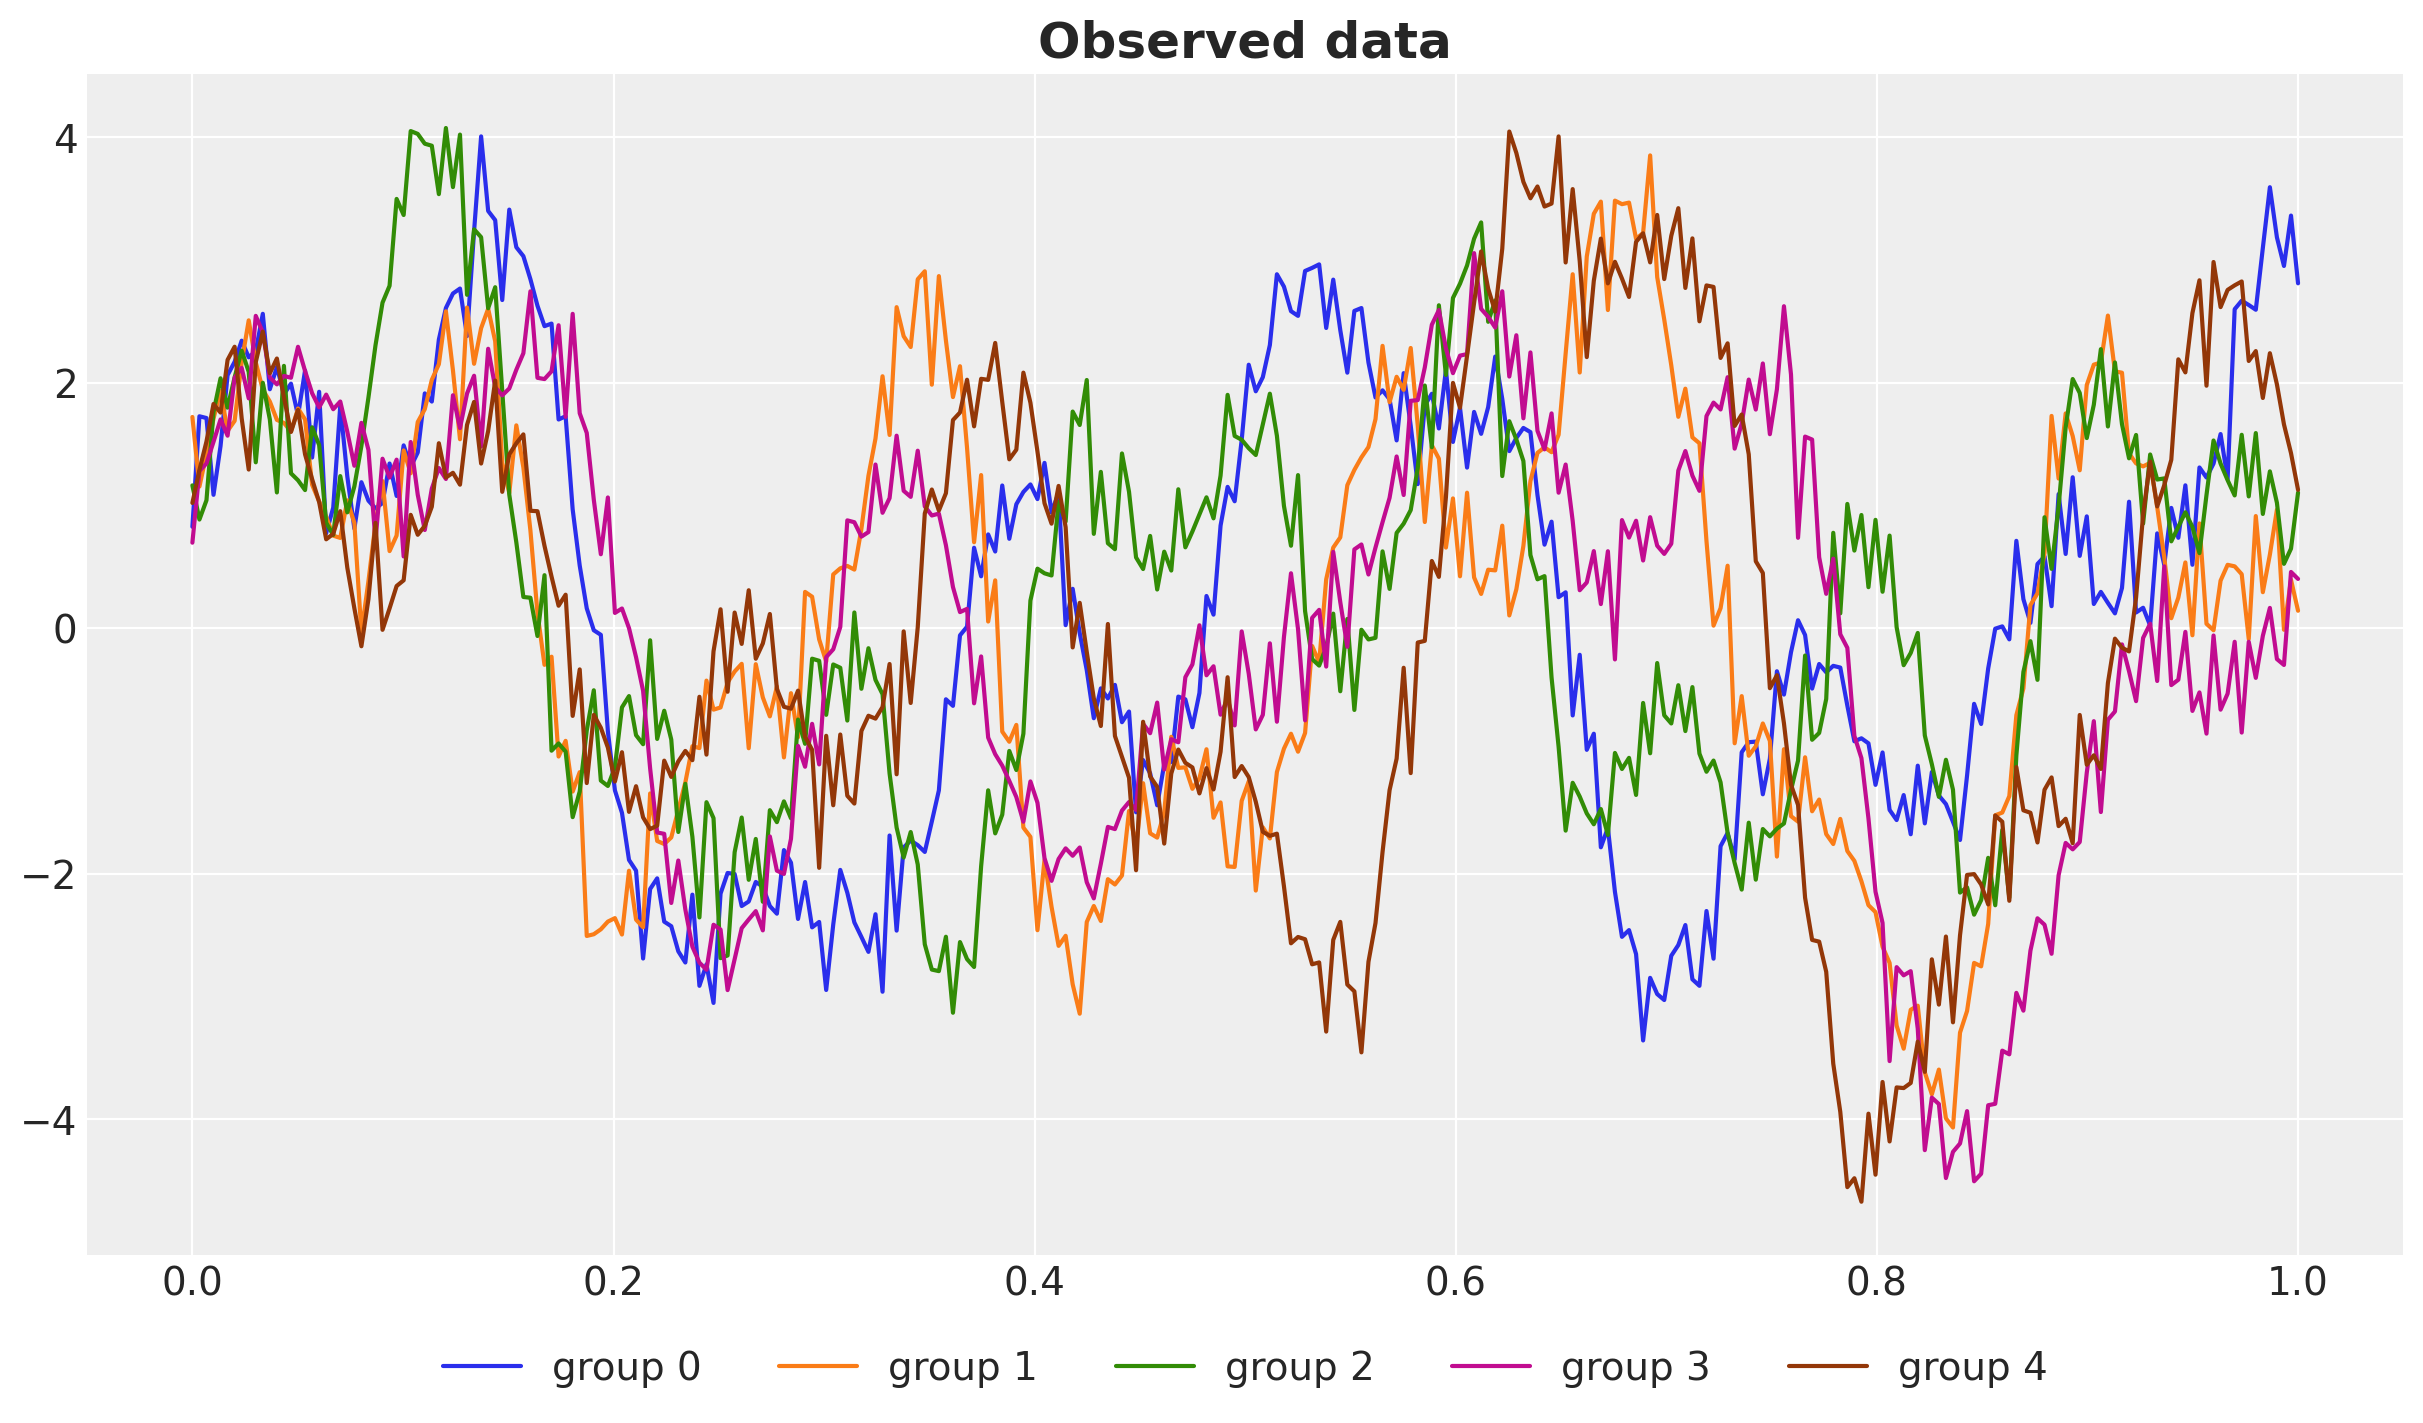

In [4]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, y[g], c=f"C{g}", label=f"group {g}")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data", fontsize=18, fontweight="bold");

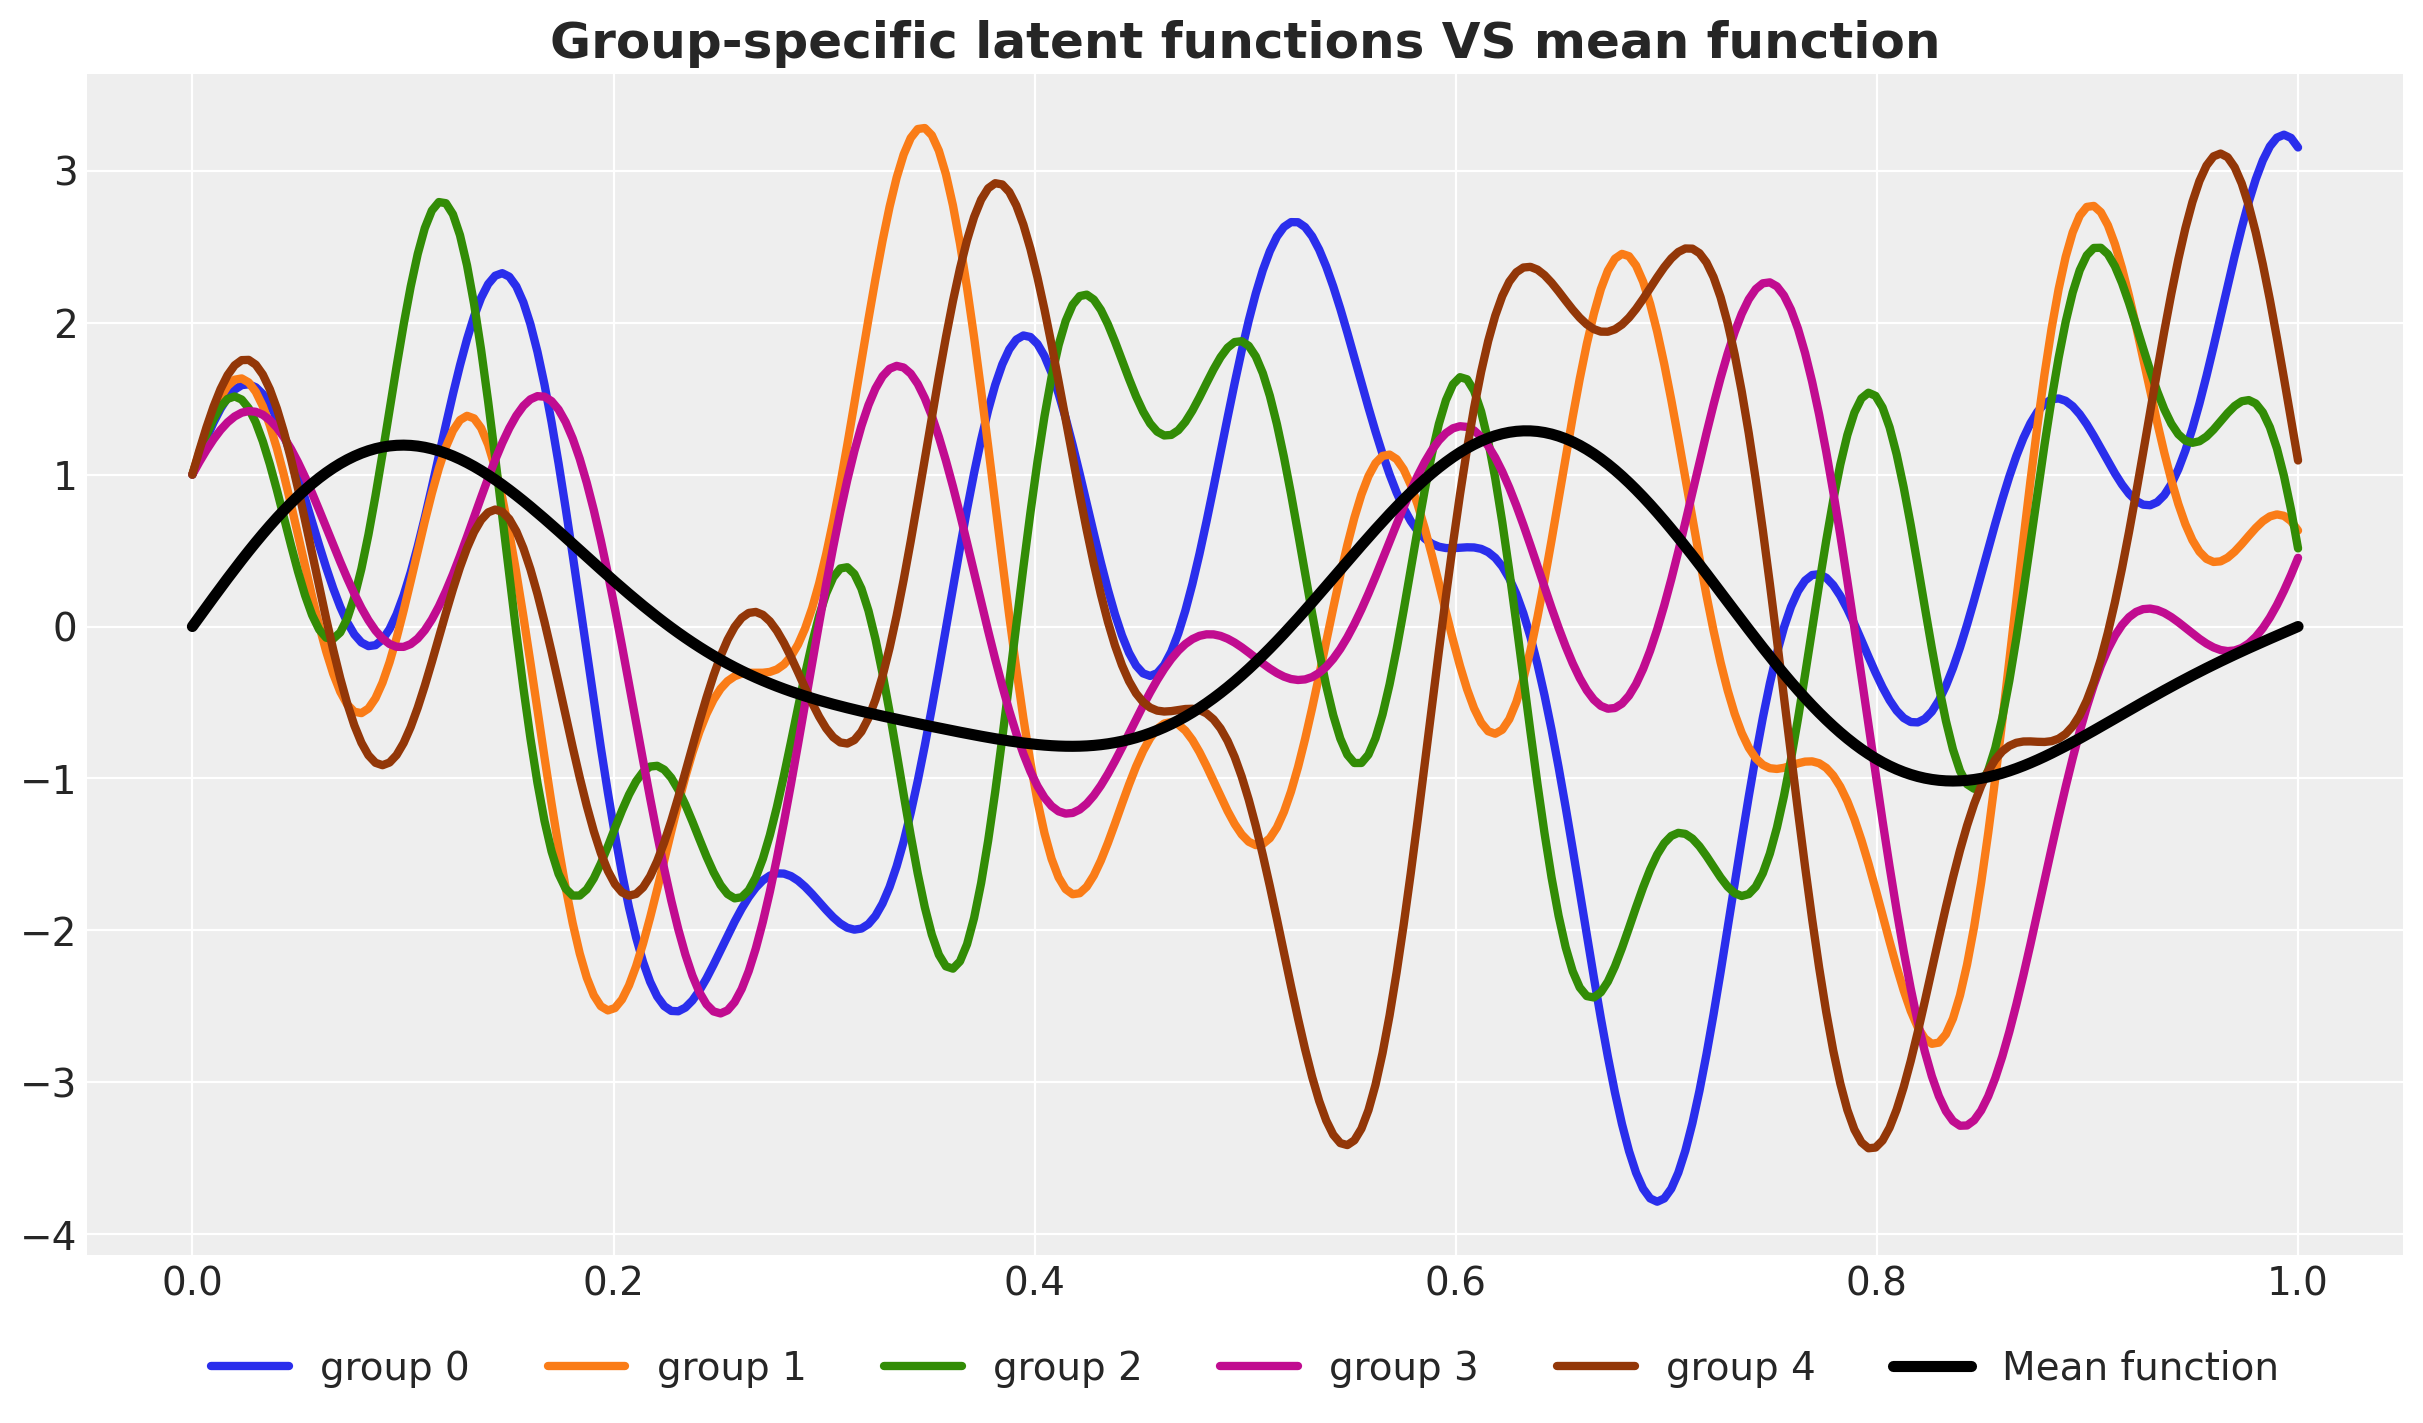

In [5]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", label=f"group {g}")

ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 1)
ax.set_title(
    "Group-specific latent functions VS mean function", fontsize=18, fontweight="bold"
);

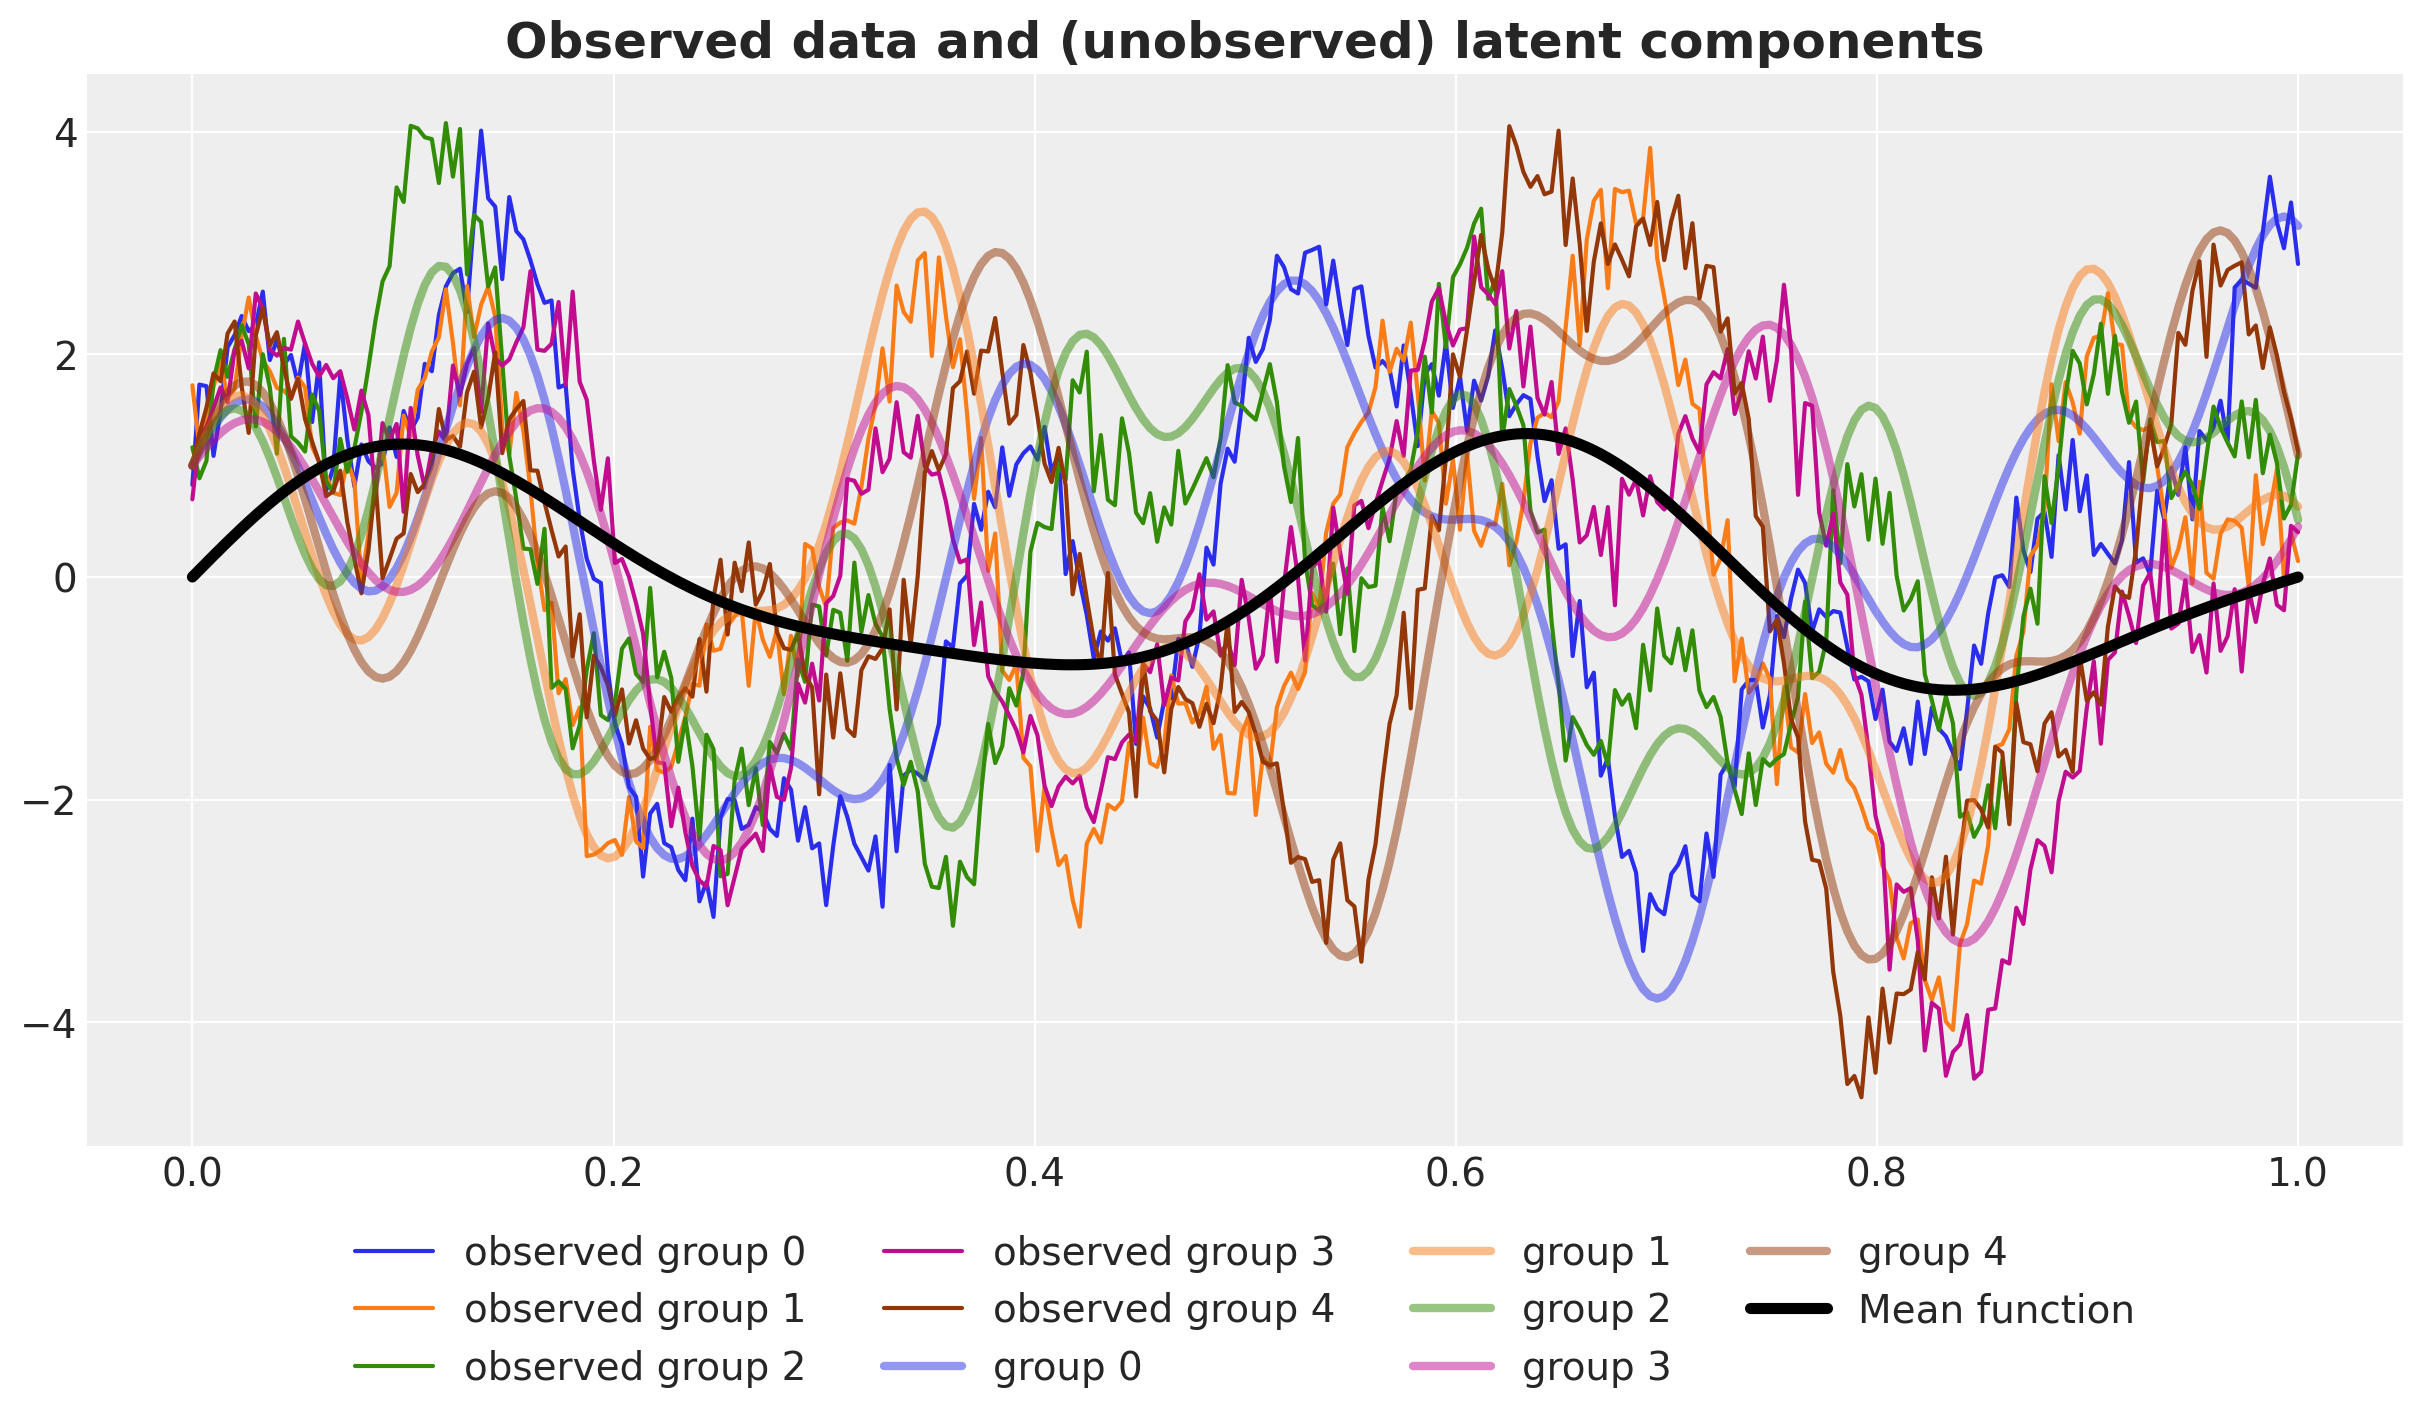

In [6]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, y[g], c=f"C{g}", label=f"observed group {g}")

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", alpha=0.5, label=f"group {g}")

ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups - 1)
ax.set_title(
    "Observed data and (unobserved) latent components", fontsize=18, fontweight="bold"
);

## Train Test Split

In [7]:
n_train = 260

x_train = x[:n_train]
x_test = x[n_train:]

y_train = y[:, :n_train]
y_test = y[:, n_train:]

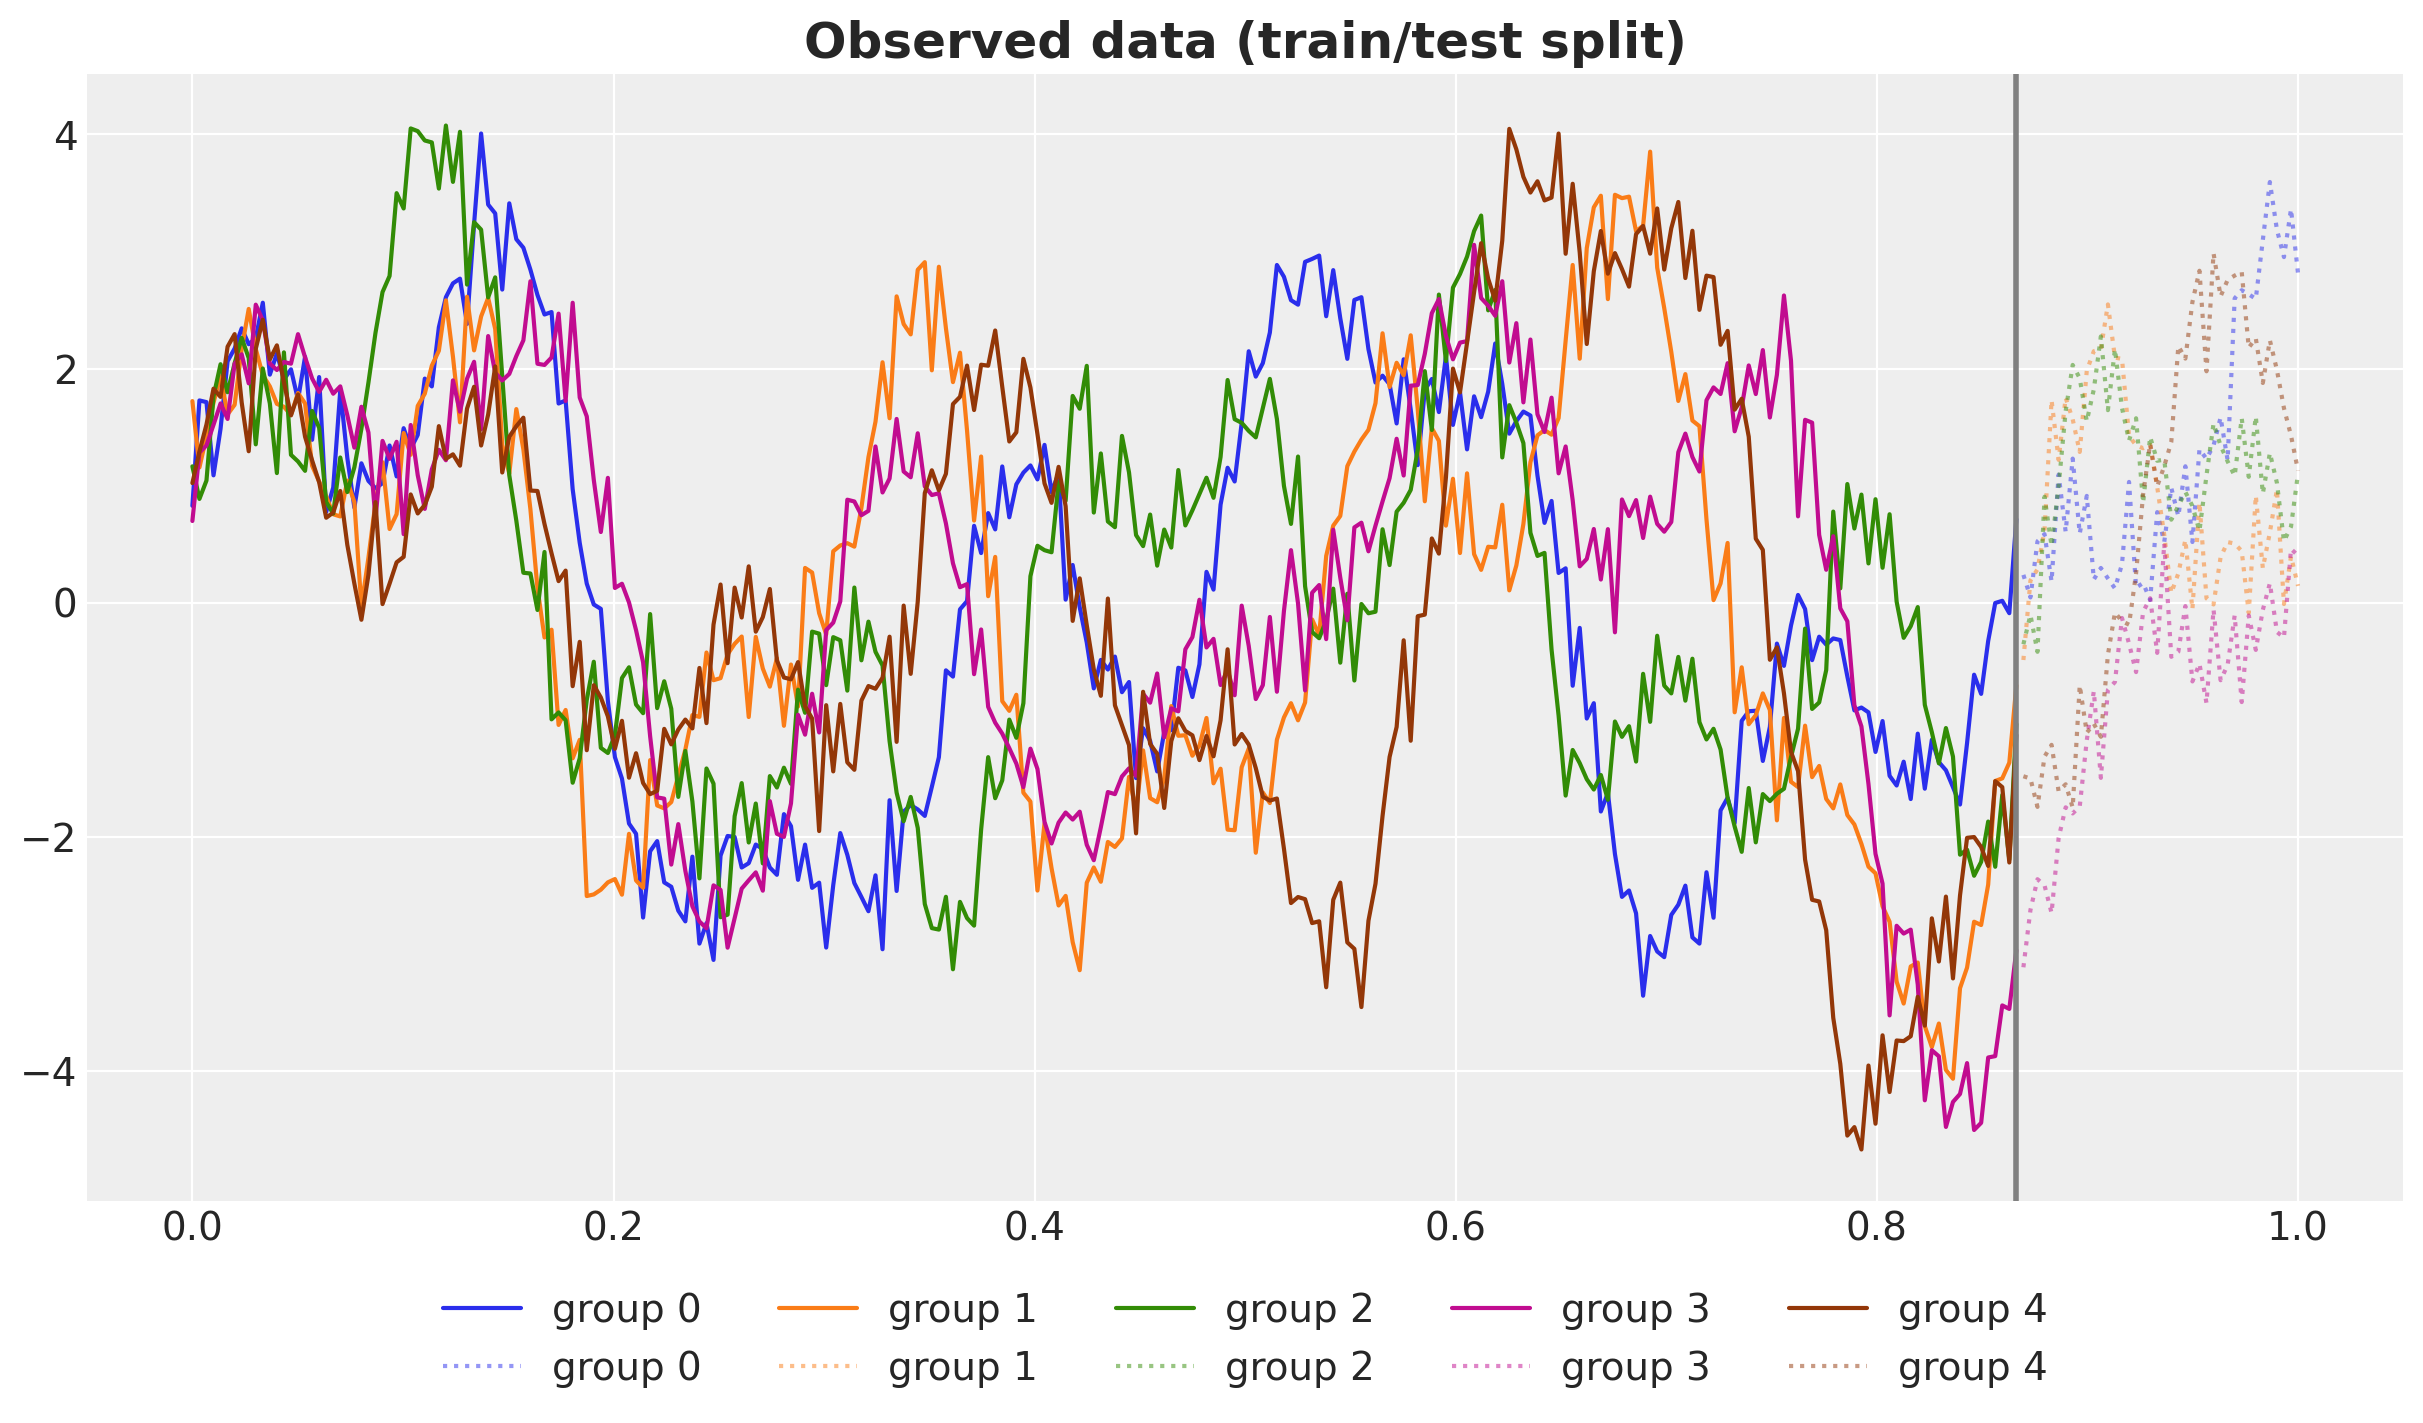

In [8]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x_train, y_train[g], c=f"C{g}", label=f"group {g}")
    ax.plot(x_test, y_test[g], c=f"C{g}", ls="dotted", alpha=0.5, label=f"group {g}")

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data (train/test split)", fontsize=18, fontweight="bold");

## Model Specification

In [9]:
def diag_spectral_density_squared_exponential_vectorized(alpha, length, ell, m, dim):
    theta = jnp.stack([alpha, length], axis=0)
    return vmap(
        lambda theta: diag_spectral_density_squared_exponential(
            alpha=theta[0],  # alpha,
            length=theta[1],  # length,
            ell=ell,
            m=m,
            dim=dim,
        ),
        in_axes=-1,
    )(theta)

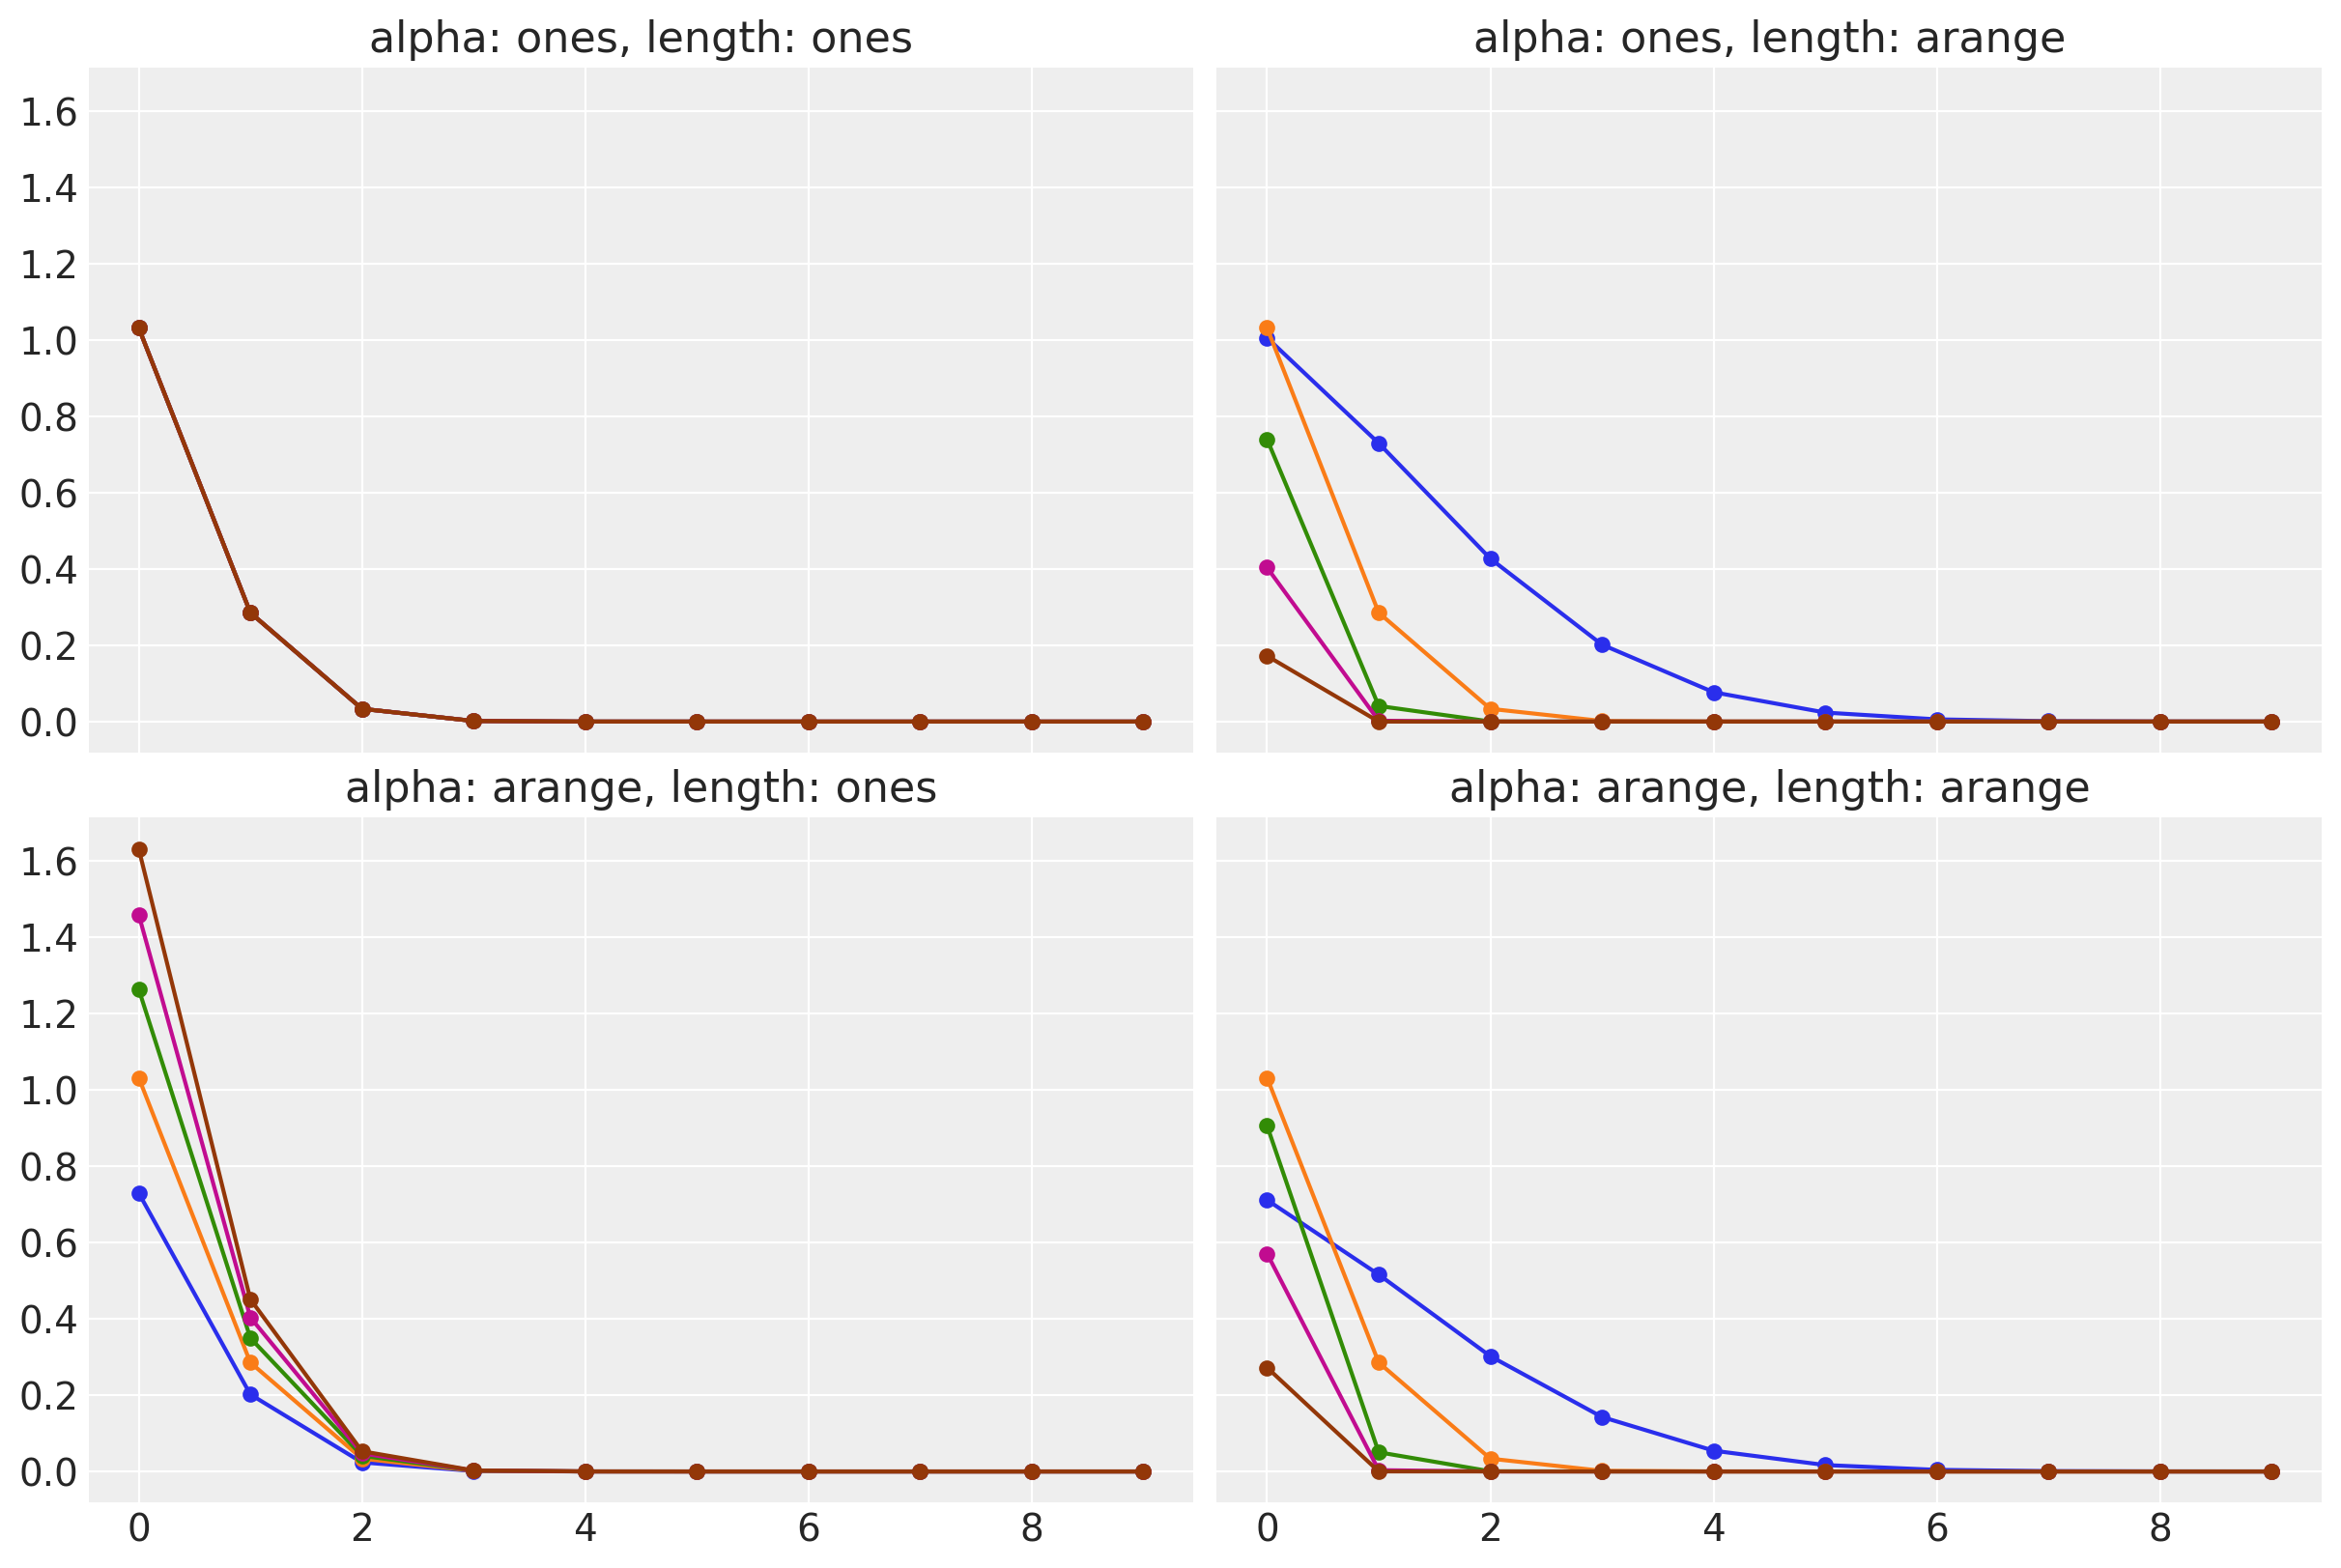

In [10]:
ell = 1.2
m = 10
dim = 1

ones_array = jnp.ones(n_groups)
arange_array = 0.5 * jnp.arange(start=1, stop=n_groups + 1, step=1)


fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True, layout="constrained"
)

for i, alpha in enumerate([ones_array, arange_array]):
    for j, length in enumerate([ones_array, arange_array]):
        spd = jnp.sqrt(
            diag_spectral_density_squared_exponential_vectorized(
                alpha=alpha,
                length=length,
                ell=ell,
                m=m,
                dim=dim,
            )
        )

        assert spd.shape == (n_groups, m)

        ax = axes[i, j]

        alpha_label = "ones" if i == 0 else "arange"
        length_label = "ones" if j == 0 else "arange"

        for g in range(n_groups):
            ax.plot(spd[g], c=f"C{g}", marker="o", markersize=5, label=f"group {g}")

        ax.set_title(f"alpha: {alpha_label}, length: {length_label}")

In [11]:
spd = jnp.sqrt(
    diag_spectral_density_squared_exponential_vectorized(
        alpha=arange_array,
        length=arange_array,
        ell=ell,
        m=m,
        dim=dim,
    )
)

for i, (single_alpha, single_length) in enumerate(
    zip(arange_array, arange_array, strict=True)
):
    assert jnp.array_equal(
        spd[i],
        jnp.sqrt(
            diag_spectral_density_squared_exponential(
                alpha=single_alpha, length=single_length, ell=ell, m=m, dim=dim
            )
        ),
    )

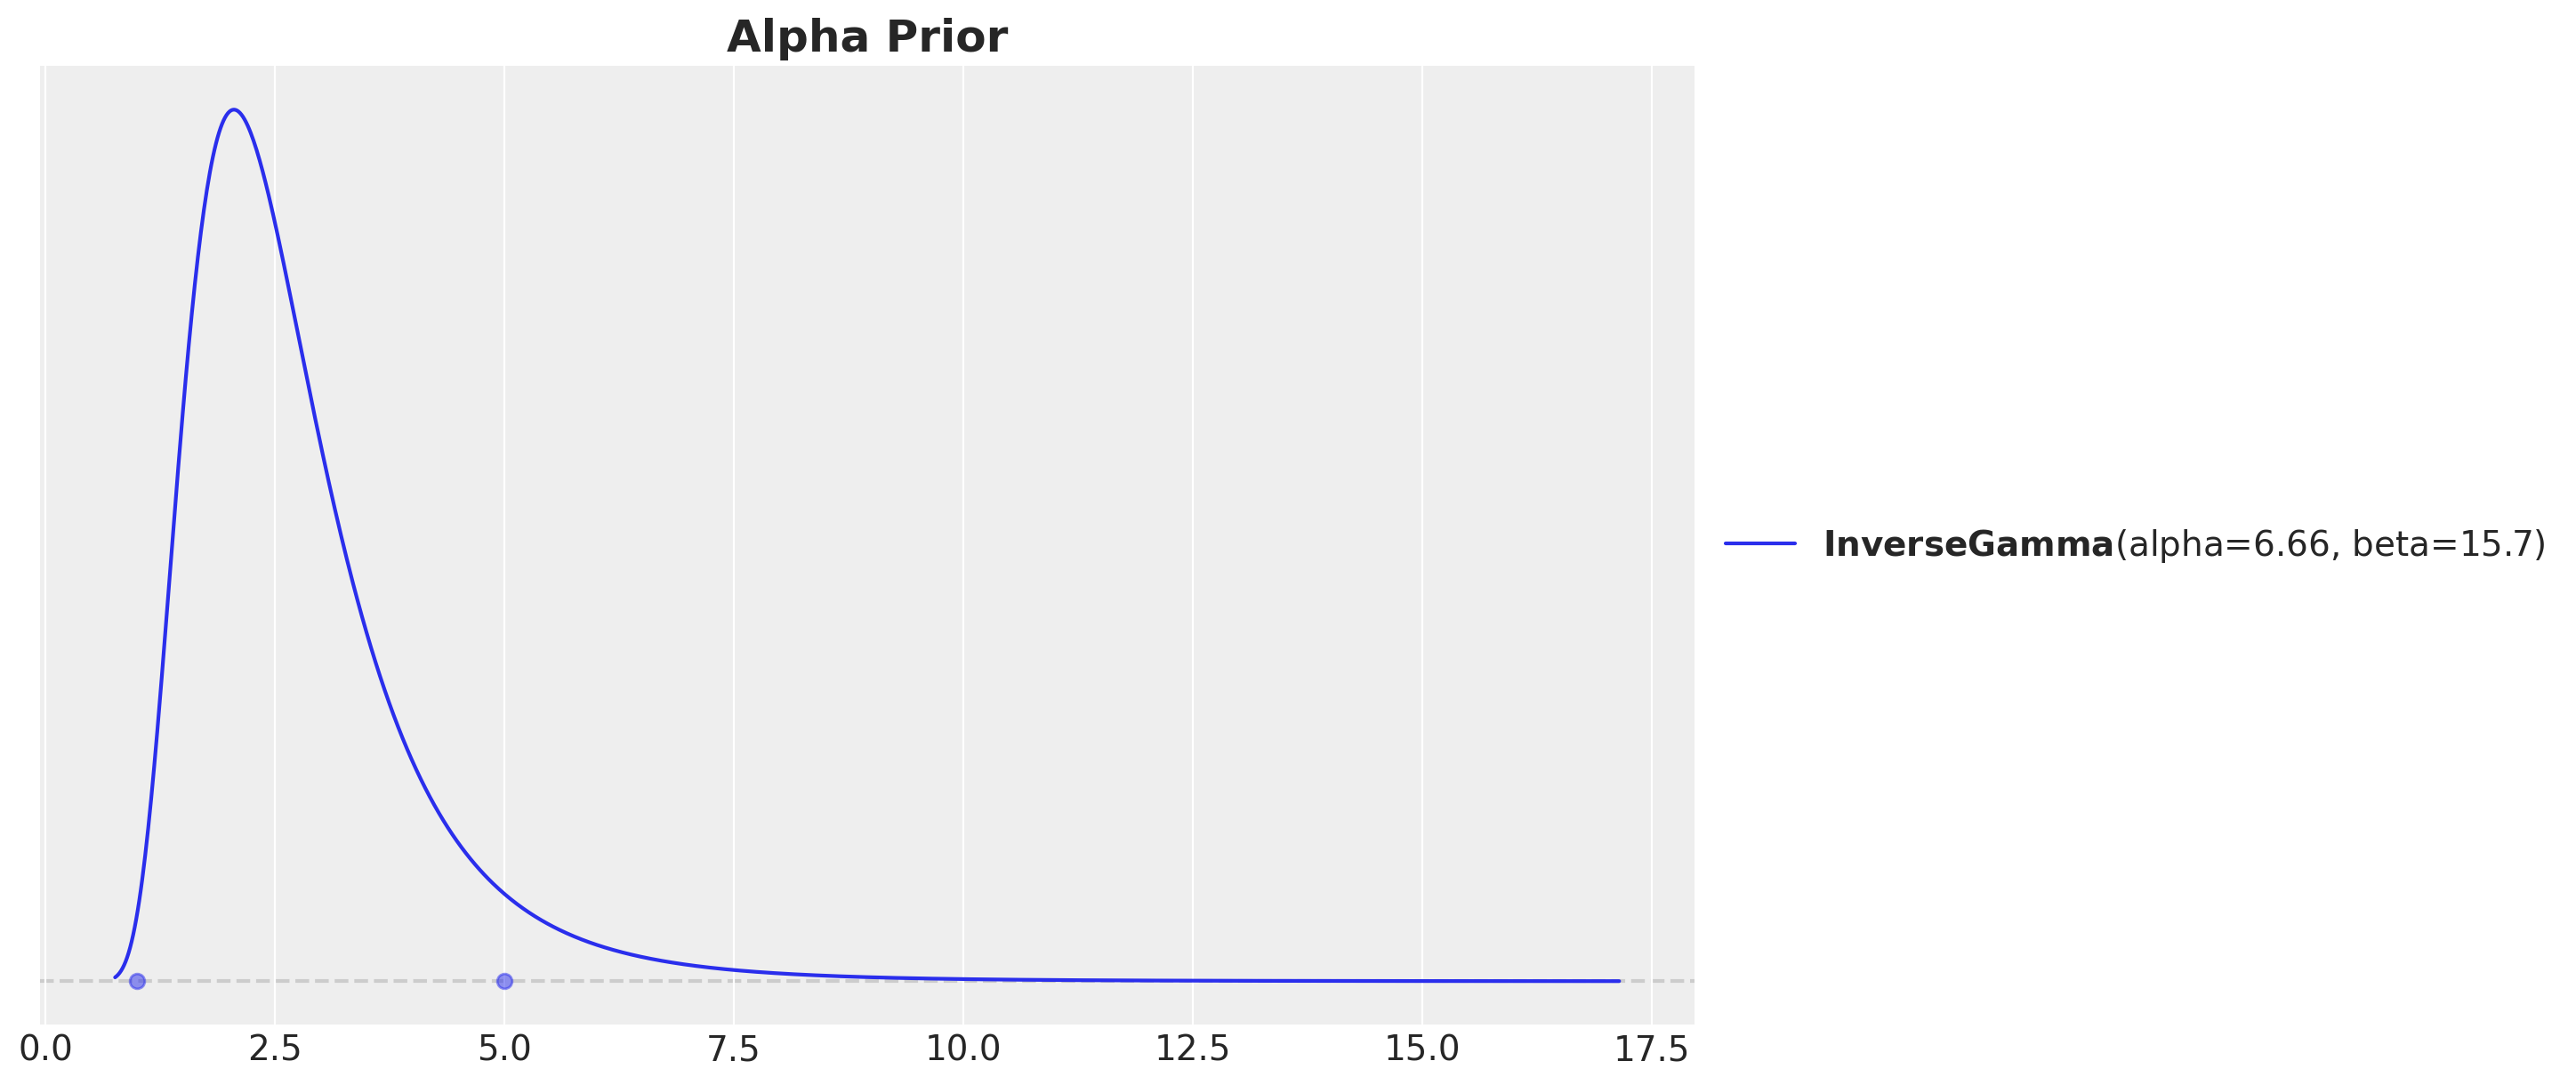

In [12]:
alpha_prior, ax = pz.maxent(pz.InverseGamma(), lower=1, upper=5, mass=0.94)
ax.set_title("Alpha Prior", fontsize=18, fontweight="bold");

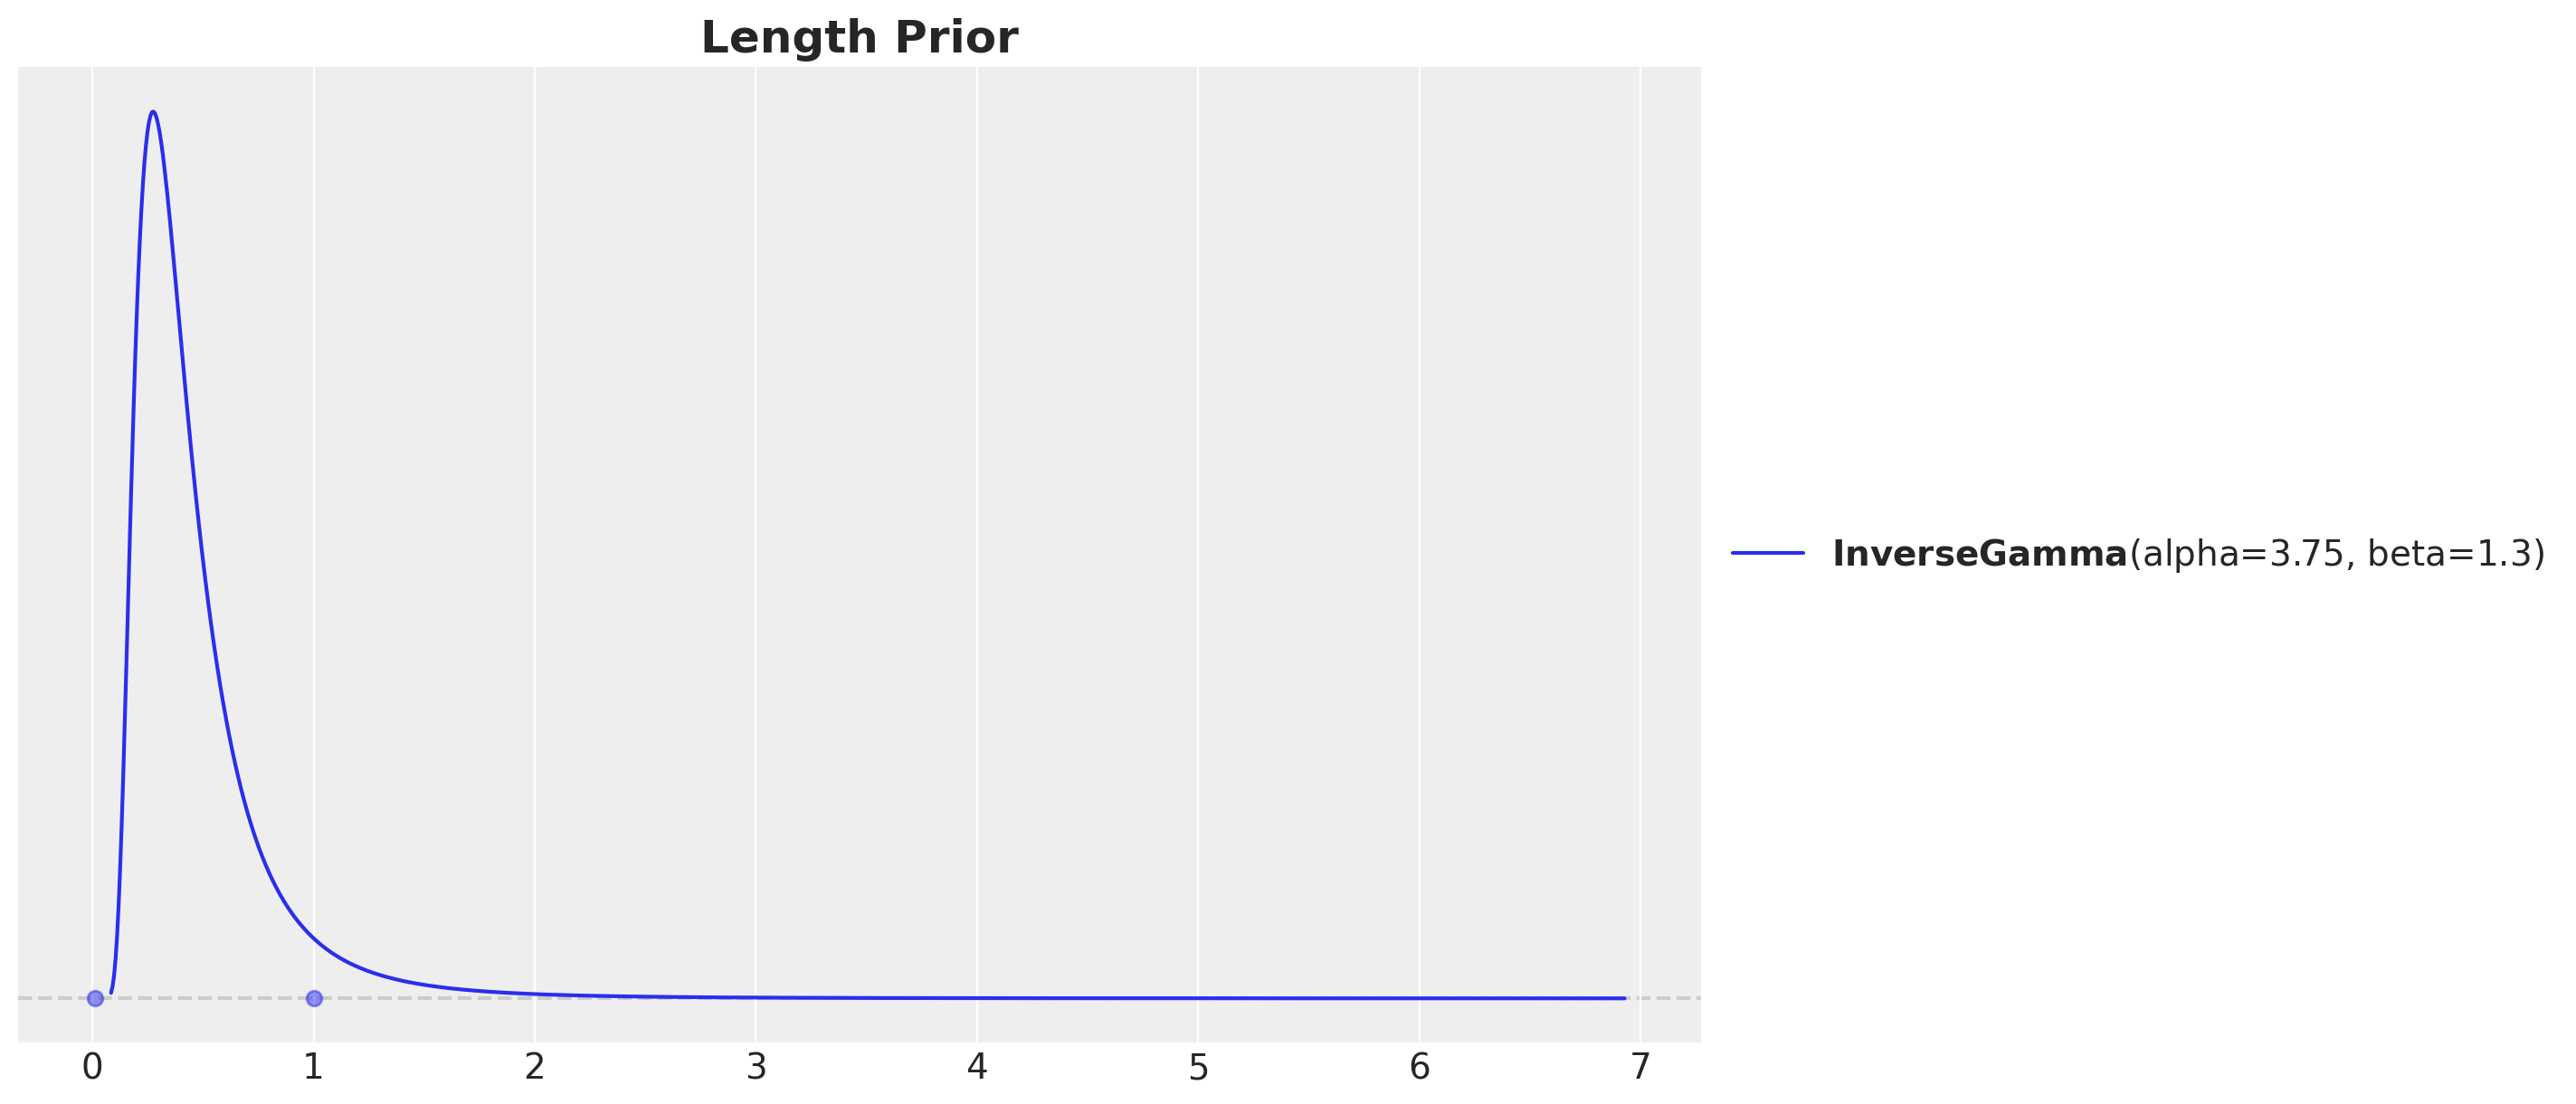

In [13]:
length_prior, ax = pz.maxent(pz.InverseGamma(), lower=0.01, upper=1, mass=0.94)
ax.set_title("Length Prior", fontsize=18, fontweight="bold");

In [14]:
def model(x, y, ell, m_global, m_groups) -> None:
    n_groups, n_obs = y.shape

    log_alpha_global = numpyro.sample(
        "log_alpha_global", dist.Normal(loc=jnp.log(10), scale=2)
    )
    log_length_global = numpyro.sample(
        "log_length_global", dist.Normal(loc=jnp.log(0.05), scale=0.05)
    )

    log_alpha_groups = log_alpha_global + numpyro.sample(
        "log_alpha_groups", dist.ZeroSumNormal(scale=0.02, event_shape=(n_groups,))
    )
    log_length_groups = log_length_global + numpyro.sample(
        "log_length_groups", dist.ZeroSumNormal(scale=0.02, event_shape=(n_groups,))
    )

    alpha_global = softplus(log_alpha_global)
    length_global = softplus(log_length_global)

    alpha_groups = softplus(log_alpha_groups)
    length_groups = softplus(log_length_groups)

    df = numpyro.sample("df", dist.Gamma(concentration=20, rate=3))
    scale_prior = numpyro.sample("scale_prior", dist.HalfNormal(scale=2))

    with numpyro.plate("groups", n_groups, dim=-1):
        scale = numpyro.sample("scale", dist.HalfNormal(scale=scale_prior))

    phi = eigenfunctions(x=x, ell=ell, m=m_groups)

    f_global = numpyro.deterministic(
        "f_global",
        scope(hsgp_squared_exponential, prefix="global", divider="::")(
            x=x,
            alpha=alpha_global,
            length=length_global,
            ell=ell,
            m=m_global,
            non_centered=True,
        ),
    )

    spd = jnp.sqrt(
        diag_spectral_density_squared_exponential_vectorized(
            alpha=alpha_groups, length=length_groups, ell=ell, m=m_groups, dim=1
        )
    )

    with (
        numpyro.plate("groups", n_groups, dim=-1),
        numpyro.plate("basis", m_groups, dim=-2),
    ):
        beta_delta = numpyro.sample("beta_delta", dist.Normal(loc=0.0, scale=1.0))

    f_delta = numpyro.deterministic("f_delta", (phi @ (spd.T * beta_delta)).T)

    f_group = numpyro.deterministic("f_group", f_global + f_delta)

    numpyro.sample("obs", dist.StudentT(df=df, loc=f_group, scale=scale[..., None]))

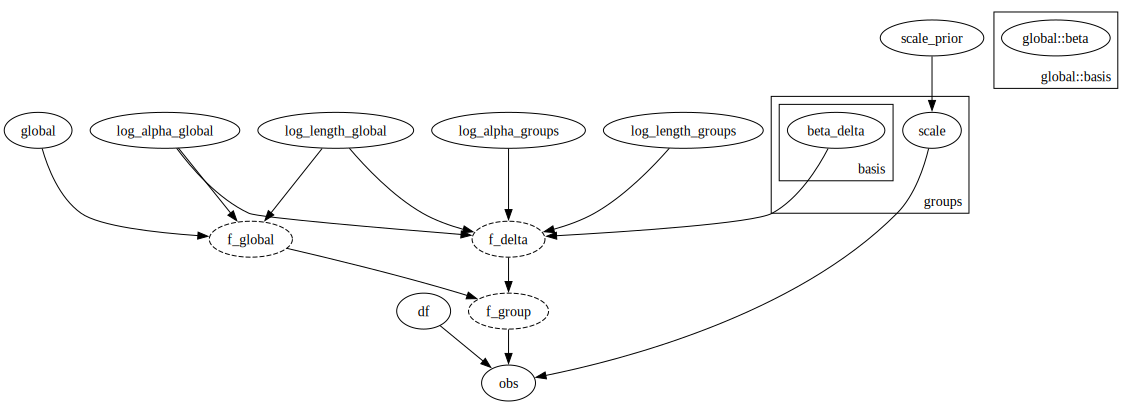

In [15]:
ell = 1.2
m_global = 30
m_groups = 20

numpyro.render_model(model, model_args=(x_train, y_train, ell, m_global, m_groups))

In [16]:
prior_predictive = Predictive(model, num_samples=100, return_sites=["obs"])


rng_key, rng_subkey = random.split(rng_key)
prior_predictive_samples = prior_predictive(
    rng_subkey, x_train, y_train, ell, m_global, m_groups
)

prior_predictive_idata = az.from_numpyro(
    prior=prior_predictive_samples,
    coords={"x": x_train, "group": jnp.arange(n_groups)},
    dims={"f": ["group", "x"], "obs": ["group", "x"]},
)

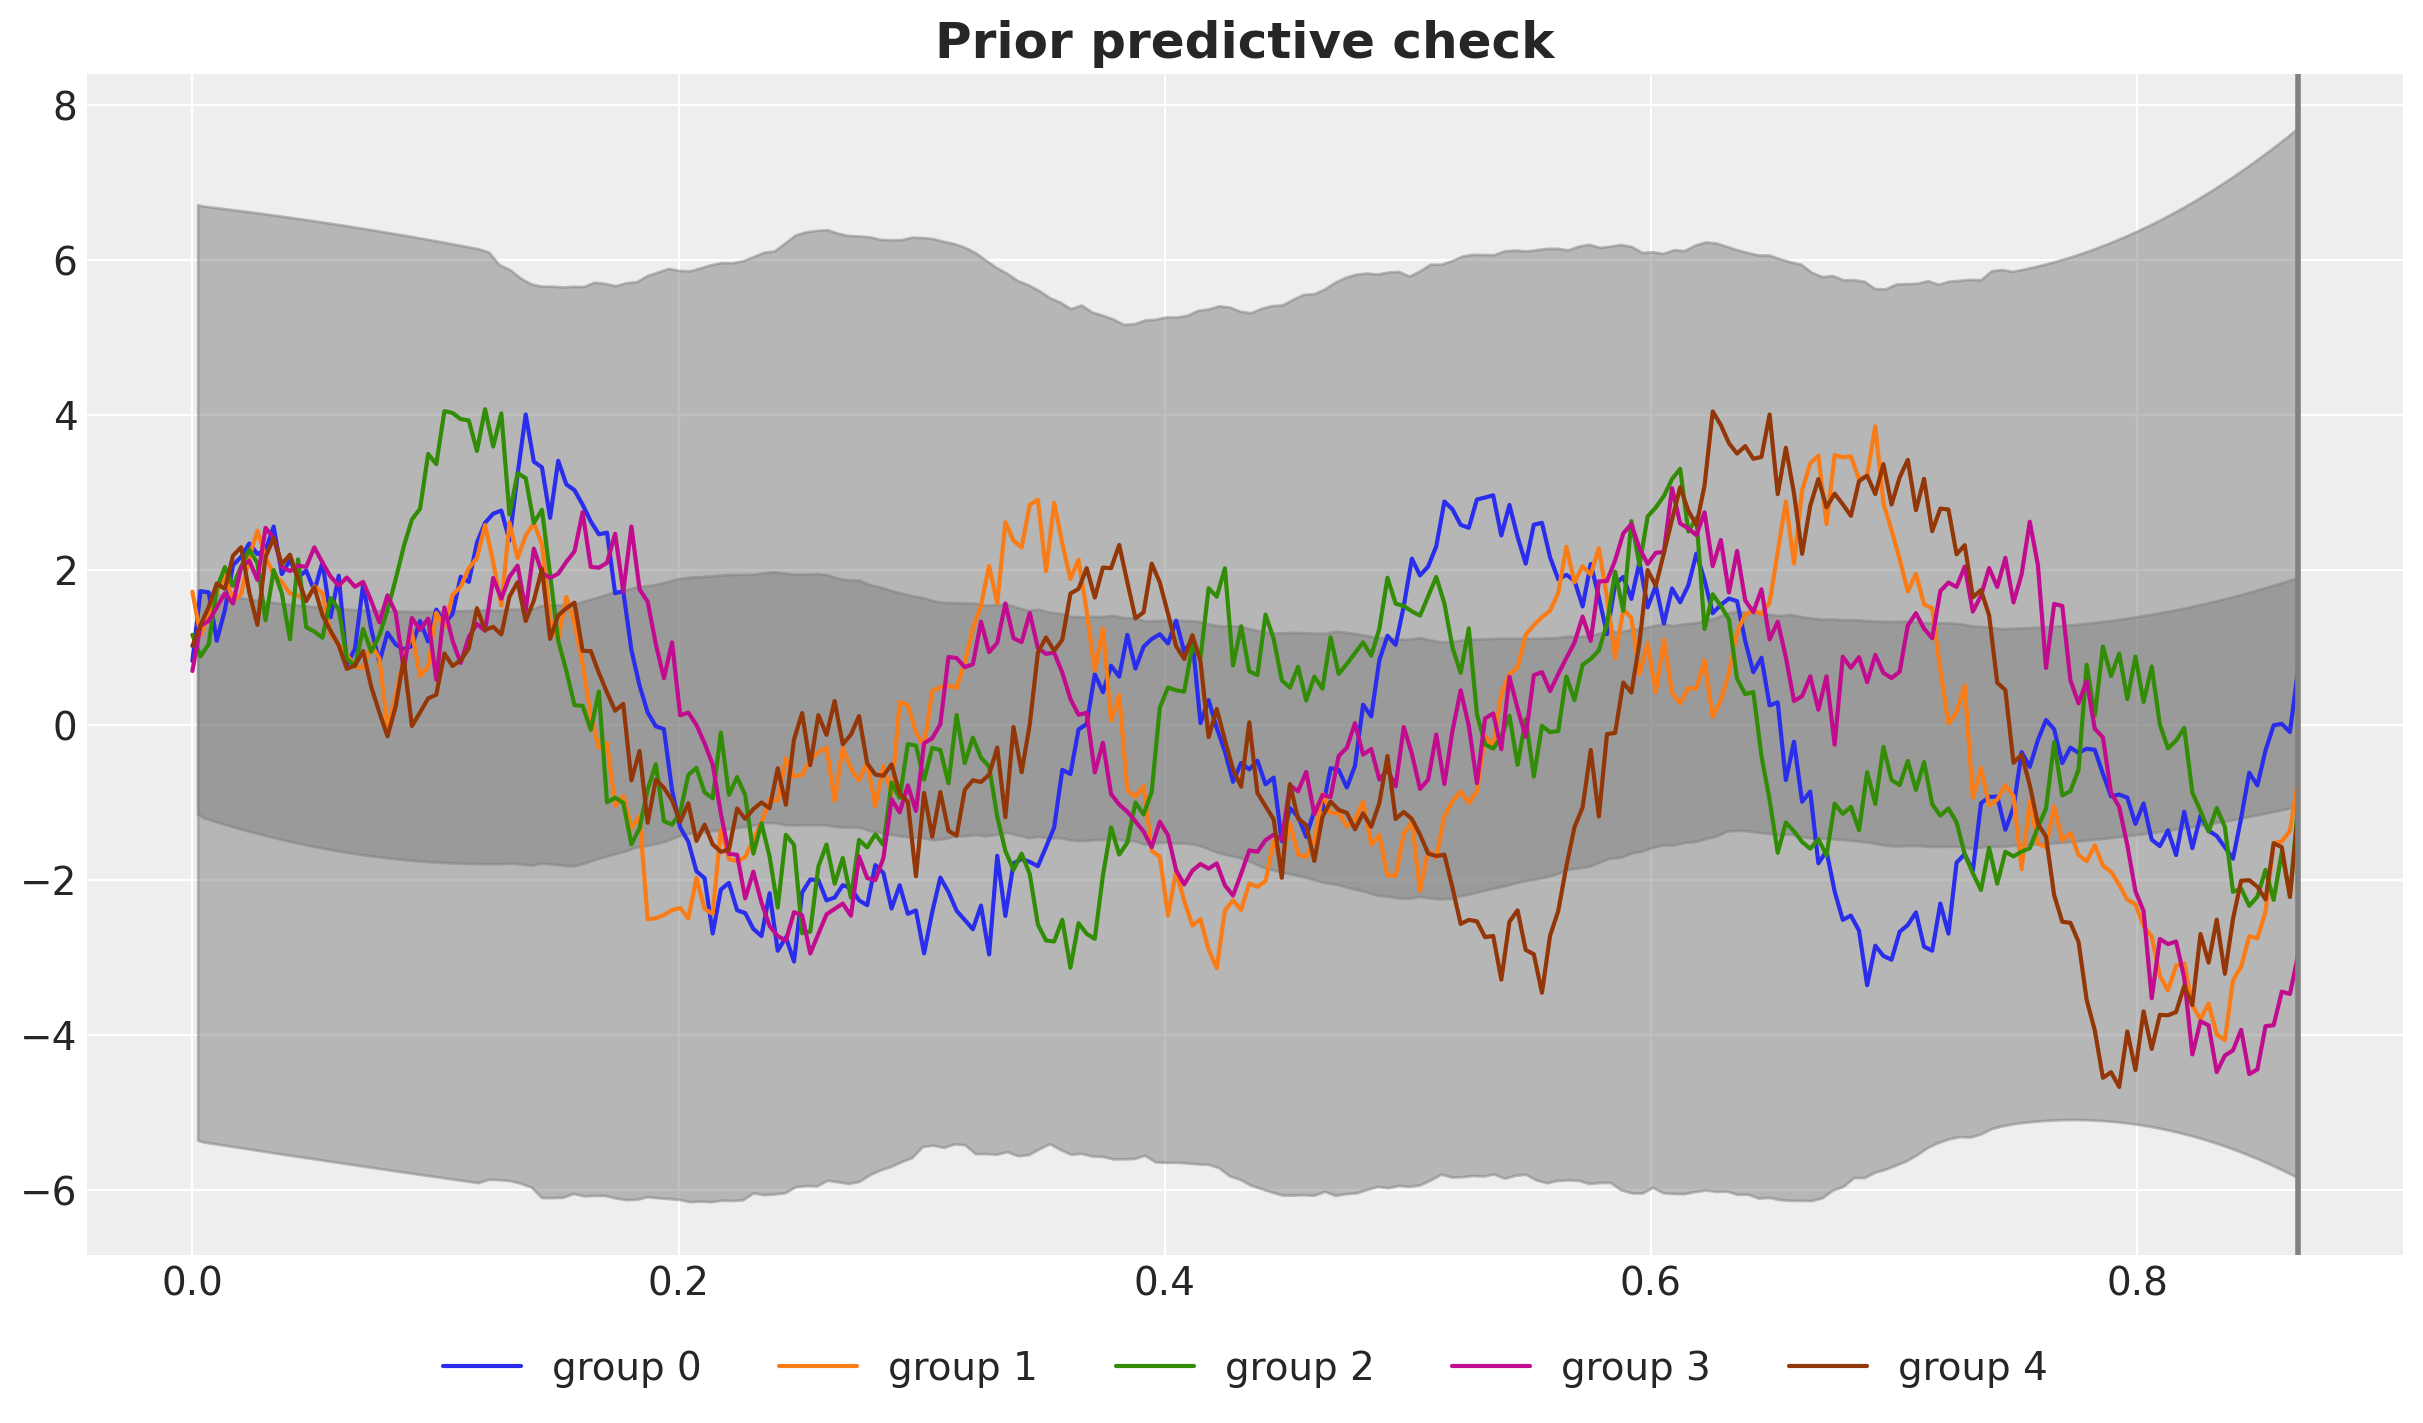

In [17]:
fig, ax = plt.subplots()

for hdi_prob in [0.5, 0.94]:
    az.plot_hdi(
        x_train,
        prior_predictive_idata["prior"]["obs"].sel(group=0),
        fill_kwargs={"color": "gray"},
        ax=ax,
        hdi_prob=hdi_prob,
    )

for g in range(n_groups):
    ax.plot(x_train, y_train[g], c=f"C{g}", label=f"group {g}")

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Prior predictive check", fontsize=18, fontweight="bold");

In [18]:
conditioned_model = condition(model, data={"obs": y_train})

sampler = NUTS(conditioned_model, target_accept_prob=0.9)

mcmc = MCMC(sampler, num_warmup=1_400, num_samples=2_000, num_chains=4)

rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, x_train, y_train, ell, m_global, m_groups)

  0%|          | 0/3400 [00:00<?, ?it/s]

  0%|          | 0/3400 [00:00<?, ?it/s]

  0%|          | 0/3400 [00:00<?, ?it/s]

  0%|          | 0/3400 [00:00<?, ?it/s]

In [19]:
idata = az.from_numpyro(
    posterior=mcmc,
    coords={
        "x": x_train,
        "group": jnp.arange(n_groups),
        "m_global": jnp.arange(m_global),
        "m_groups": jnp.arange(m_groups),
    },
    dims={
        "alpha_groups": ["group"],
        "length_groups": ["group"],
        "beta": ["m_global", "m_groups"],
        "beta_delta": ["m_groups", "group"],
        "f_delta": ["group", "x"],
        "f_global": ["x"],
        "f_group": ["group", "x"],
        "obs": ["group", "x"],
    },
)

In [20]:
idata["sample_stats"].diverging.sum().item()

0

In [21]:
az.summary(
    idata,
    var_names=[
        "log_alpha_global",
        "log_length_global",
        "log_alpha_groups",
        "log_length_groups",
        "scale",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log_alpha_global      8.113  1.211   5.778   10.301      0.019    0.013   
log_length_global    -3.035  0.046  -3.117   -2.943      0.000    0.000   
log_alpha_groups[0]  -0.000  0.018  -0.033    0.034      0.000    0.000   
log_alpha_groups[1]   0.000  0.018  -0.034    0.033      0.000    0.000   
log_alpha_groups[2]  -0.000  0.018  -0.033    0.033      0.000    0.000   
log_alpha_groups[3]   0.000  0.018  -0.032    0.034      0.000    0.000   
log_alpha_groups[4]   0.000  0.018  -0.032    0.035      0.000    0.000   
log_length_groups[0] -0.000  0.018  -0.032    0.035      0.000    0.000   
log_length_groups[1]  0.000  0.018  -0.033    0.035      0.000    0.000   
log_length_groups[2]  0.000  0.018  -0.033    0.033      0.000    0.000   
log_length_groups[3] -0.000  0.018  -0.033    0.032      0.000    0.000   
log_length_groups[4] -0.000  0.018  -0.034    0.033      0.000    0.000   
scale[0]              0.725  0.037   0.660    0.800      0.000    0.000   
scale[1]              0.843  0.045   0.760    0.928      0.000    0.000   
scale[2]              1.023  0.054   0.921    1.122      0.001    0.000   
scale[3]              0.588  0.036   0.522    0.657      0.000    0.000   
scale[4]              0.735  0.037   0.668    0.806      0.000    0.000   

                      ess_bulk  ess_tail  r_hat  
log_alpha_global        4106.0    5290.0    1.0  
log_length_global      11074.0    5901.0    1.0  
log_alpha_groups[0]    13705.0    6054.0    1.0  
log_alpha_groups[1]    12338.0    5379.0    1.0  
log_alpha_groups[2]    12336.0    5422.0    1.0  
log_alpha_groups[3]    13536.0    6040.0    1.0  
log_alpha_groups[4]    14593.0    5807.0    1.0  
log_length_groups[0]   13064.0    5571.0    1.0  
log_length_groups[1]   11695.0    5102.0    1.0  
log_length_groups[2]   14448.0    5989.0    1.0  
log_length_groups[3]   15266.0    5660.0    1.0  
log_length_groups[4]   13035.0    5844.0    1.0  
scale[0]               12851.0    6434.0    1.0  
scale[1]               12369.0    6386.0    1.0  
scale[2]               10830.0    5969.0    1.0  
scale[3]                9583.0    6523.0    1.0  
scale[4]               12377.0    6153.0    1.0

In [22]:
posterior_predictive = Predictive(
    model, posterior_samples=mcmc.get_samples(), return_sites=["obs"]
)

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey, x_train, y_train, ell, m_global, m_groups
)

idata.extend(
    az.from_numpyro(
        posterior_predictive=posterior_predictive_samples,
        coords={"x": x_train, "group": jnp.arange(n_groups)},
        dims={"f_group": ["group", "x"], "obs": ["group", "x"]},
    )
)

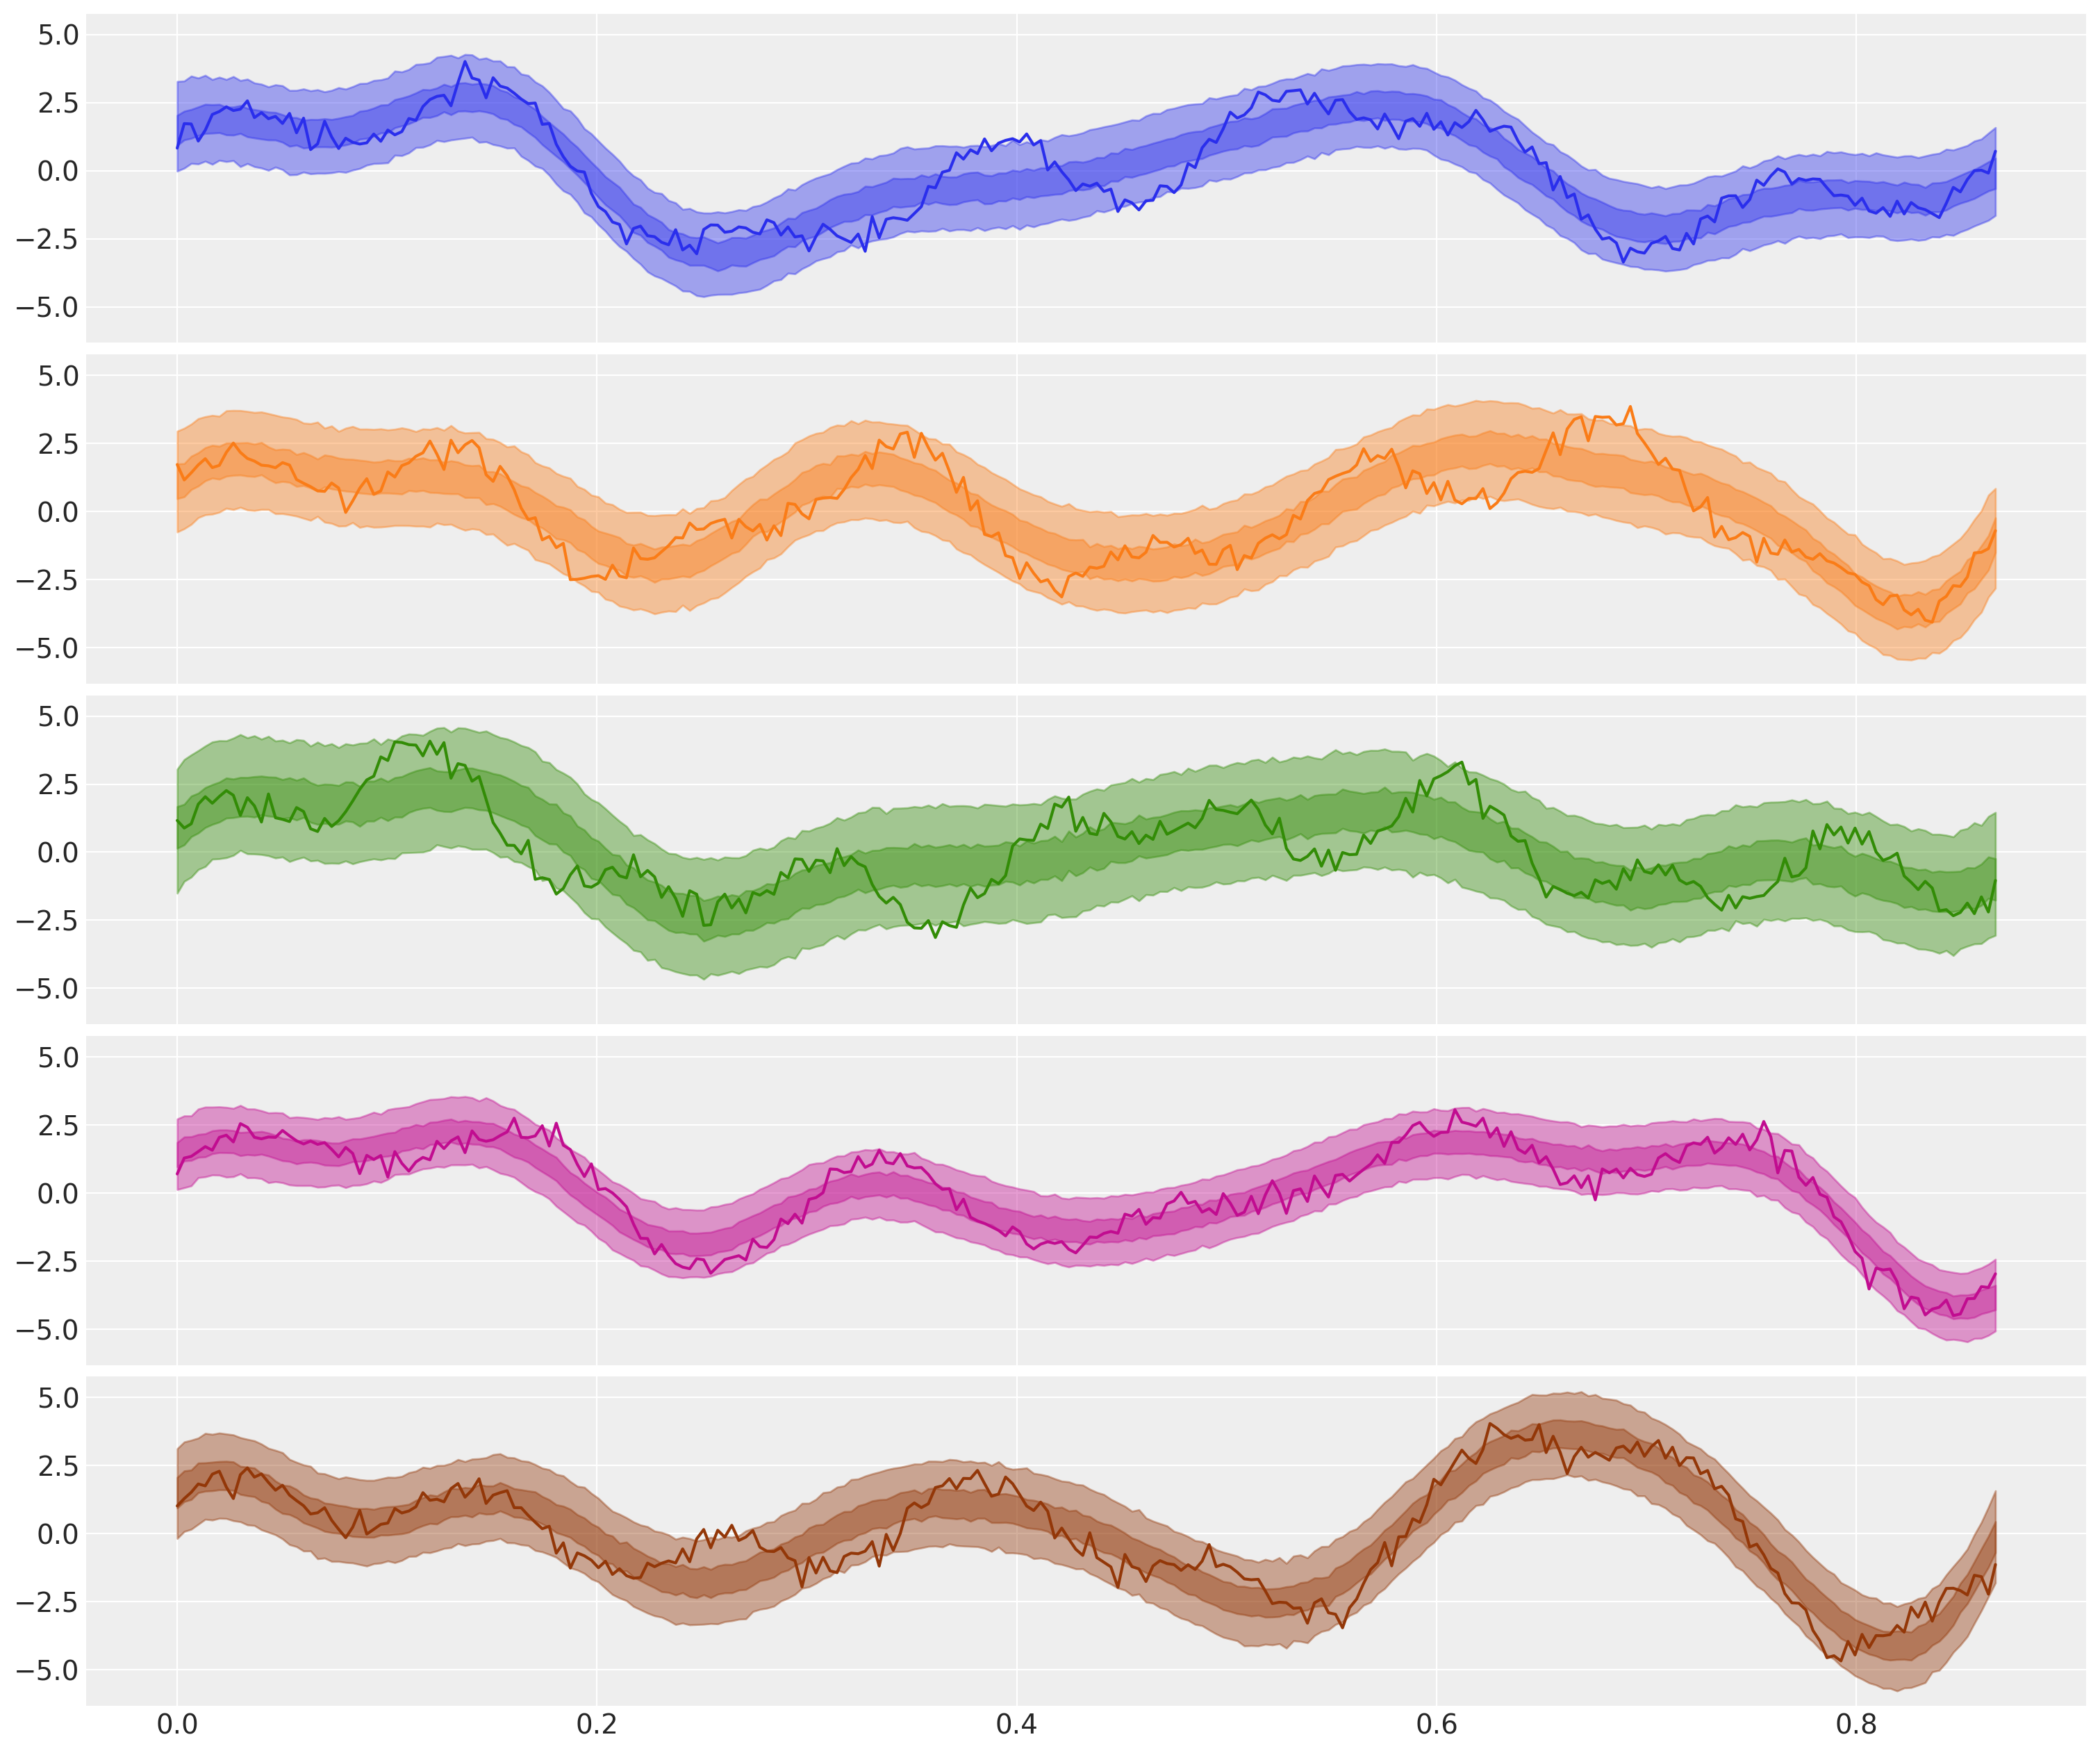

In [23]:
fig, axes = plt.subplots(
    nrows=n_groups,
    ncols=1,
    figsize=(15, 2.5 * n_groups),
    sharex=True,
    sharey=True,
    layout="constrained",
)


for group in range(n_groups):
    for hdi_prob in [0.5, 0.94]:
        az.plot_hdi(
            x_train,
            idata["posterior_predictive"]["obs"].sel(group=group),
            fill_kwargs={"color": f"C{group}", "alpha": 0.4},
            ax=axes[group],
            hdi_prob=hdi_prob,
            smooth=False,
        )

    axes[group].plot(x_train, y_train[group], c=f"C{group}", label=f"group {group}")

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Posterior predictive check", fontsize=18, fontweight="bold");

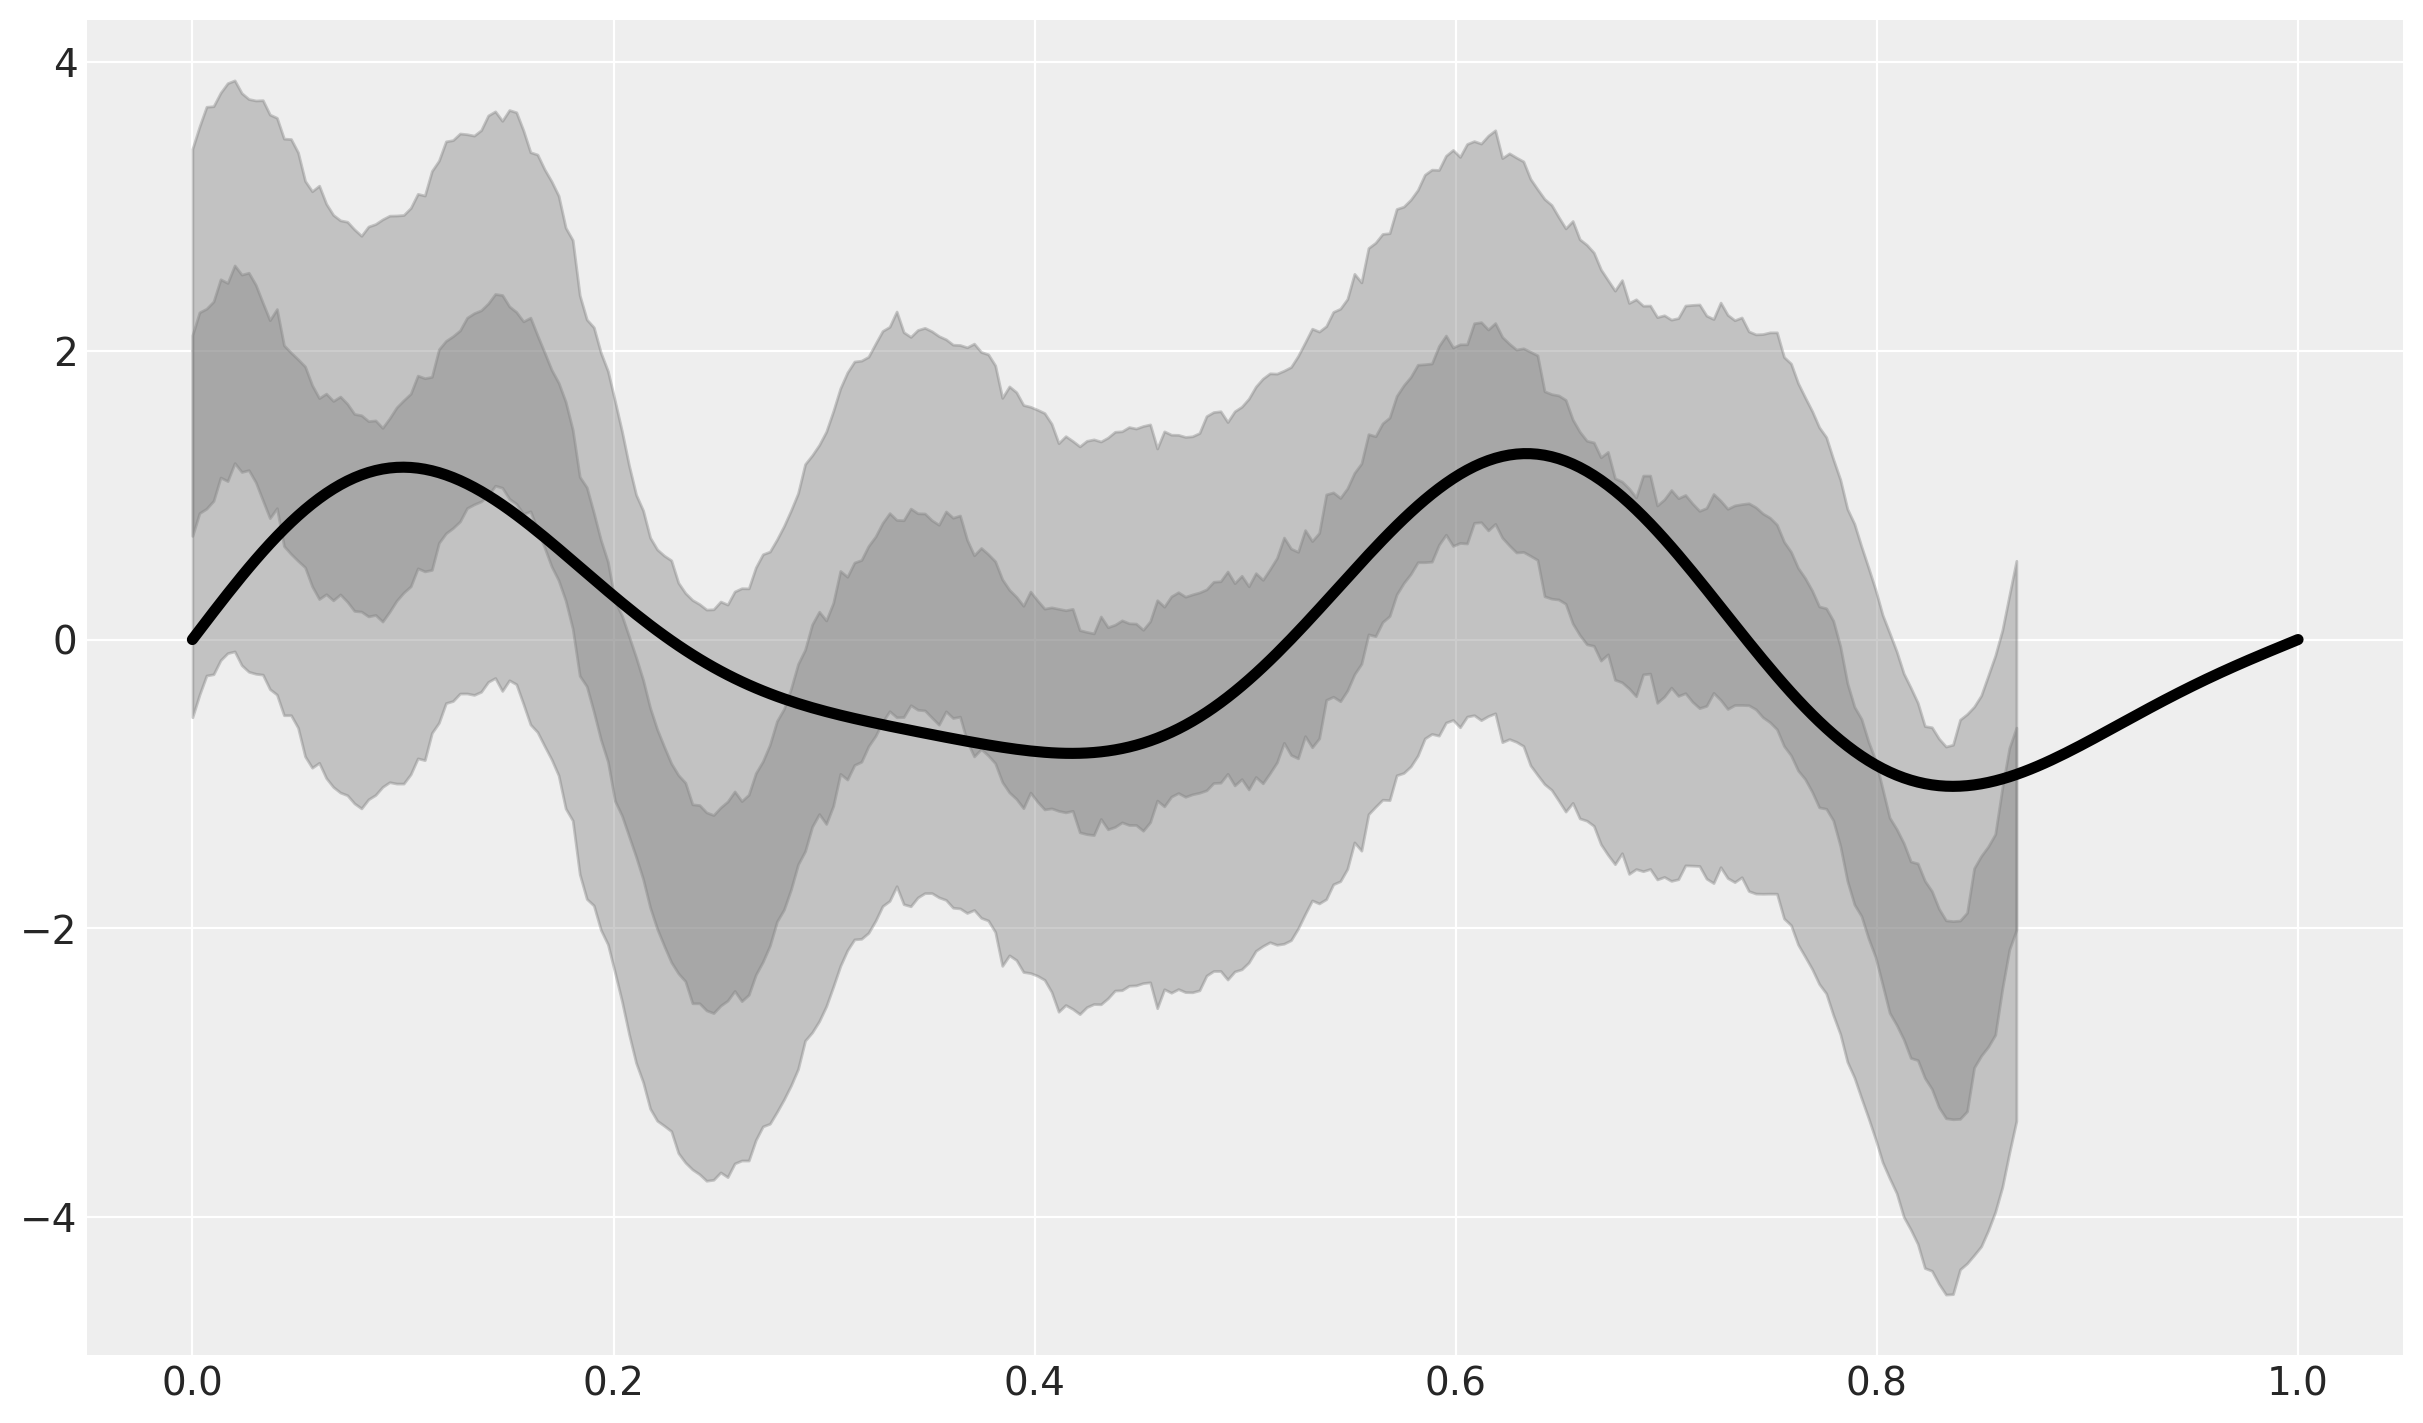

In [24]:
fig, ax = plt.subplots()
for hdi_prob in [0.5, 0.94]:
    az.plot_hdi(
        x_train,
        idata["posterior"]["f_global"],
        fill_kwargs={"color": "gray", "alpha": 0.4},
        ax=ax,
        hdi_prob=hdi_prob,
        smooth=False,
    )
ax.plot(x, f[0], c="black", lw=4, label="Mean function")